<a href="https://colab.research.google.com/github/fizmat/compare-gpu-lib/blob/master/comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [0]:
import platform, os
dist = platform.dist()[0]
if dist == 'Ubuntu':
  !apt install -y --no-install-recommends -q nvidia-cuda-toolkit
  !apt-get install lshw clinfo
  
  !pip install numba
  os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/lib/nvidia-cuda-toolkit/libdevice"
  os.environ['NUMBAPRO_NVVM'] = "/usr/lib/x86_64-linux-gnu/libnvvm.so"
  
  !pip install pycuda
  
  !pip install pyopencl==2016.1

elif dist == 'arch':
  !sudo pacman -S cuda lshw clinfo  --needed --noconfirm
  cuda_bin = "/opt/cuda/bin/"
  if not cuda_bin in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + cuda_bin
  
  !pip install numba
  os.environ['NUMBAPRO_LIBDEVICE'] = "/opt/cuda/nvvm/libdevice"
  os.environ['NUMBAPRO_NVVM'] = "/opt/cuda/nvvm/lib64/libnvvm.so"

  !sudo pacman -S python-pycuda --needed --noconfirm
  
  !sudo pacman -S python-pyopencl --needed --noconfirm

Reading package lists...
Building dependency tree...
Reading state information...
nvidia-cuda-toolkit is already the newest version (9.1.85-3ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
clinfo is already the newest version (2.2.18.03.26-1).
lshw is already the newest version (02.18-0.1ubuntu6.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
!nvcc --version
!nvidia-smi
!lshw -numeric -C display
!clinfo


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Tue_Jun_12_23:07:04_CDT_2018
Cuda compilation tools, release 9.2, V9.2.148
Wed Dec  5 14:07:04 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

# Common code

In [0]:
from collections import namedtuple
Data = namedtuple('Data', 'charges masses pos vel')
SplitData = namedtuple('SplitData', 'charges masses p0 p1 v0 v1')

## Generate parameters and data

In [0]:
import numpy as np
import math

def gen_pos(n, size):
  steps = math.ceil(math.sqrt(n))
  full_grid = np.mgrid[0:steps, 0:steps].reshape(2, steps*steps).transpose()
  n_grid_points = np.ascontiguousarray(full_grid[:n])
  return size/steps * (n_grid_points+0.5)

def gen_vel(n, max_vel):
  return (np.random.rand(n, 2) - 0.5)*max_vel

class TaskGenerator:
  def __init__(self, pos_t=np.float32, vel_t=np.float32, time_t=np.float32,
               mass_t=np.float32, charge_t=np.float32, scalar=False,
               dist=10, max_vel=1, mass=2, charge=1, dt = 0.1):
    self.dist = pos_t(dist)
    self.max_vel = vel_t(max_vel)
    self.mass = mass_t(mass)
    self.charge = charge_t(charge)
    self.dt = time_t(dt)
    self.scalar = scalar
    
  def __repr__(self):
    typed = lambda x: f"{type(x)}({x})"
    params = ', '.join(f'{s}={typed(getattr(self, s))}' for s in ('dist', 'max_vel', 'mass', 'charge', 'dt'))
    return f"{self.__class__}({params}, {'scalar' if self.scalar else 'vector'})"

  def __str__(self):
    typed = lambda x: f"{type(x).__name__}({x:.3f})"
    params = ', '.join(f'{s}={typed(getattr(self, s))}' for s in ('dist', 'max_vel', 'mass', 'charge', 'dt'))
    return f"{self.__class__.__name__}({params}, {'scalar' if self.scalar else 'vector'})"
  
  @staticmethod
  def gen_data(n, size, max_vel, charge, mass, scalar):
    pos = gen_pos(n, size).astype(type(size))
    vel = gen_vel(n, max_vel).astype(type(max_vel))
    charges = charge if scalar else np.full(n, charge)
    masses = mass if scalar else np.full(n, mass)
    return Data(charges, masses, pos, vel)

  def gen_on_scale(self, scale):
    n = scale*scale
    size = type(self.dist)(self.dist * scale)
    return self.dt, n, size, self.gen_data(n, size, self.max_vel, self.charge, self.mass, self.scalar)


## Abstract solver class

In [0]:
from time import perf_counter
from enum import Enum, auto
from jinja2 import Template

class CoordFormat(Enum):
  nx = auto()
  xn = auto()
  split = auto()

f=np.float32

class Solver:
  no_blocks = False
  perf_good_batch_crits = (24, 64)
  tpl = Template("")
  
  def __init__(self, coord_format=CoordFormat.xn, scalar=False, threadsperblock=64, types={}):
    self.format = coord_format
    self.scalar = scalar
    self.threadsperblock = threadsperblock
    f = np.float32
    self.types = {s: f for s in ("pos_t", "vel_t", "time_t", "charge_t", "mass_t")}
    self.types.update(types)
    self.source = self.tpl.render(format=coord_format.name, scalar=scalar,
                                  **{k: v.__name__ for k, v in self.types.items()})
   
  def __repr__(self):
    return f"{self.__class__.__name__}({self.format.name}, {self.threadsperblock})"
  
  def _to_device(self, host_array):
    return host_array.copy()

  def _to_host(self, dev_array, host_array):
    return dev_array.copy()
    
  def call(self, foo, *args, **kwargs):
    return foo(*args, **kwargs)
  
  @staticmethod
  def update(self, *args, **kwargs):
    raise NotImplementedError()

  @staticmethod
  def update_v(self, *args, **kwargs):
    raise NotImplementedError()
  
  @staticmethod
  def update_p(self, *args, **kwargs):
    raise NotImplementedError()
  
  @staticmethod
  def rebound(self, *args, **kwargs):
    raise NotImplementedError()
        
  def to_device(self, host_value):
    return self._to_device(np.ascontiguousarray(host_value)) if isinstance(host_value, np.ndarray) else host_value

  def to_host(self, dev_value, host_value):
    return self._to_host(dev_value, host_value) if isinstance(host_value, np.ndarray) else dev_value

  def to_device_all(self, host_data):
    return type(host_data)(*(self.to_device(x) for x in host_data))
    
  def to_host_all(self, dev_data, host_data):
    return type(host_data)(*(self.to_host(a, b) for a, b in zip(dev_data, host_data)))
  
  def to_device_layout(self, data):
    if self.format == CoordFormat.nx:
      return Data(*data)
    elif self.format == CoordFormat.xn:
      return Data(data.charges, data.masses, data.pos.transpose(), data.vel.transpose())
    elif self.format == CoordFormat.split:
      return SplitData(data.charges, data.masses, data.pos[:, 0], data.pos[:, 1], data.vel[:, 0], data.vel[:, 1])
    
  def to_host_layout(self, data):
    if self.format == CoordFormat.nx:
      return Data(*data)
    elif self.format == CoordFormat.xn:
      return Data(data.charges, data.masses, data.pos.transpose(), data.vel.transpose())
    elif self.format == CoordFormat.split:
      return Data(data.charges, data.masses, np.stack((data.p0, data.p1), axis=1), np.stack((data.v0, data.v1), axis=1))
    
  def step(self, dt, size, n, dd, compound_step):
    if self.format == CoordFormat.split:
      if compound_step:
        self.call(self.update_v, dd.p0, dd.p1, dd.v0, dd.v1, dt, dd.charges, dd.masses, n)
        self.call(self.update_p, dd.p0, dd.p1, dd.v0, dd.v1, dt, n)
        self.call(self.rebound, dd.p0, dd.p1, dd.v0, dd.v1, size, n)
      else:
        self.call(self.update, dd.p0, dd.p1, dd.v0, dd.v1, dt, size, dd.charges, dd.masses, n)
    else:
      if compound_step:
        self.call(self.update_v, dd.pos, dd.vel, dt, dd.charges, dd.masses, n)
        self.call(self.update_p, dd.pos, dd.vel, dt, n)
        self.call(self.rebound, dd.pos, dd.vel, size, n)
      else:
        self.call(self.update, dd.pos, dd.vel, dt, size, dd.charges, dd.masses, n) 
  
  def simulate(self, dt, n, size, time_steps, save_step, compound_step, data):
    self.blockspergrid = math.ceil(n / self.threadsperblock)
    batches = [save_step]*(time_steps//save_step) + [time_steps%save_step]
    ti = 0
    host_data = self.to_device_layout(data)
    dev_data = self.to_device_all(host_data)
    host_data = self.to_host_all(dev_data, host_data)
    yield (ti, ti*dt, perf_counter(), self.to_host_layout(host_data))
    for batch_size in batches:
      if batch_size==0: # skip last (remainder) batch if it's not needed
        continue 
      for i in range(batch_size):
        self.step(dt, size, np.int32(n), dev_data, compound_step)
      host_data = self.to_host_all(dev_data, host_data)
      ti += batch_size;
      yield (ti, ti*dt, perf_counter(), self.to_host_layout(host_data))


## Check distribution fits

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rayleigh, norm, kstest

def plot_maxwell(vel, label=None, draw=True):
  speed = (vel*vel).sum(1)**0.5
  loc, scale = rayleigh.fit(speed, floc=0)
  dist = rayleigh(scale=scale)
  if draw:
    plt.hist(speed, 20, normed=True)
    x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 1000)
    plt.plot(x, dist.pdf(x), label=label)
    if label:
      plt.legend()
  return kstest(speed, dist.cdf)[0]

def plot_maxwell_x(vel, label=None, draw=True):
  loc, scale = norm.fit(vel[:, 0], floc=0)
  dist = norm(scale=scale)
  if draw:
    plt.hist(vel[:, 0], 20, normed=True)
    x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 1000)
    plt.plot(x, dist.pdf(x), label=label)
    if label:
      plt.legend()
  return kstest(vel[:, 0], dist.cdf)[0]
    
def plot_particles(pos, vel):
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.quiver(pos[:, 0], pos[:, 1], vel[:, 0], vel[:, 1])

def multi_particles(f, title=None, n=None, width=4.5, height=4):
  if n is None:
    n = min(5, len(f.data))
  fig = plt.figure(figsize=(width*n, height))
  if title:
    fig.suptitle(title)
  for i in range(n):
    plt.subplot(1, n, i+1)
    j = math.floor(i*(len(f.data)-1)/(n-1))
    plt.title(f"t = {f.time[j]:.1f}")
    r = f.data[j]
    plot_particles(r.pos, r.vel)

def multi_maxwell(f, title=None, n=None, draw=True, width=20, height=2):
  if n is None:
    n = len(f.data)
  if draw:
    fig = plt.figure(figsize=(width, height*n))
    if title:
      fig.suptitle(title)
  max_vel = max((r.vel*r.vel).sum(1).max() for r in f.data)**0.5
  max_x = max((np.abs(r.vel[:,0])).max() for r in f.data)
  fits = []
  for i in range(n):
    j = i*(len(f.data)-1)/(n-1)
    r = f.data[j]
    if draw:
      plt.subplot(n, 2, 2*i+1)
      plt.xlim(0, max_vel)
    f1 = plot_maxwell(r.vel, f"t = {f.time[j]:.1f}", draw)
    if draw:
      plt.subplot(n, 2, 2*i+2)
      plt.xlim(-max_x, max_x)
    f2 = plot_maxwell_x(r.vel, f"t = {f.time[j]:.1f}", draw)
    fits.append({"t": f.time[j], "speed_stat":f1, "xvel_stat":f2})
  return pd.DataFrame.from_records(fits, index='t')

def run_simulation(generator, solver, compound_step=True, scale=16,
         time_steps=500, save_step=100):
  dt, n, size, data = generator.gen_on_scale(scale)
  frame = pd.DataFrame(solver.simulate(dt, n, size, time_steps, save_step, compound_step, data), columns=["t", "time", "perf", "data"])
  return frame

def plot_and_fit(frame, title="", draw_particles=True, draw_maxwell=True,
         particles_width=2.5, particles_height=2,
         maxwell_width=10, maxwell_height=1):
  if draw_particles:
    multi_particles(frame, None, width=particles_width, height=particles_height)
  fits = multi_maxwell(frame, title, draw=draw_maxwell, width=maxwell_width, height=maxwell_height)
  return fits


In [0]:
import sys

def check(generator, solver, compound, **sim_kwargs):
  result = run_simulation(generator, solver, compound, **sim_kwargs)
  fits = plot_and_fit(result, draw_maxwell=False, draw_particles=False)
  fits = pd.DataFrame( {"initial":fits.iloc[0], "final":fits.iloc[-1]}, columns = ("initial","final"))
  fits["improvement"] = fits.initial/fits.final
  return fits, result

floats = [np.float32, np.float64]
ints = [np.int32, np.float32, np.float64]

def gen_all_types():
  for p in floats:
    for v in floats:
      for t in floats:
        for m in ints:
          for c in ints:
              yield {"pos_t": p, "vel_t": v, "time_t": t, "mass_t": m, "charge_t": c}

def gen_sane_types():
  for f in floats:
    for i in ints:
        yield {"pos_t": f, "vel_t": f, "time_t": f, "mass_t": i, "charge_t": i}

def gen_one_types():
  f = np.float32
  yield {"pos_t": f, "vel_t": f, "time_t": f, "mass_t": f, "charge_t": f}
        
def gen_sane_params():
  for form in CoordFormat:
    for scalar in True, False:
      for compound in True, False:
        yield locals()

def gen_one_params():
  form = CoordFormat.nx
  scalar = False
  compound = True
  yield locals()               
  
sane_tpbs=(32, 64, 128, 256)
one_tpbs=(64,)
many_tbps=(8, 16, 32, 48, 64, 128, 192, 256, 384, 512)
        
def check_fits(SolverClass, tpbs=one_tpbs, types=list(gen_sane_types()), params=list(gen_sane_params()), Generator=TaskGenerator, **sim_kwargs):
  for t in types:
    for p in params:
      for tpb in (1,) if SolverClass.no_blocks else tpbs:
        solver = SolverClass(types=t, coord_format=p['form'], threadsperblock=tpb, scalar=p['scalar'])
        result = {k: v.__name__ for k, v in t.items()}
        result.update(p)
        result["tpb"] = tpb
        result["form"] = p["form"].name
        sys.stdout.write("\r" + str(result))
        fits, data = check(Generator(scalar=p['scalar'], **t), solver, p['compound'], **sim_kwargs)
        result["fit_speed"] = fits.final.speed_stat
        result["fit_xvel"] = fits.final.xvel_stat
        result["data"] = data
        yield result
            
def pick_outliers(checks):
  outliers = checks[np.logical_or(checks.fit_speed==checks.fit_speed.max(), checks.fit_xvel==checks.fit_xvel.max())]
  for d in outliers.data:
    multi_particles(d)
  return outliers

def test_fits(SolverClass, gen_types=gen_sane_types, **sim_kwargs):
  checks = pd.DataFrame.from_records(check_fits(SolverClass, **sim_kwargs))
  for k, c in checks[pd.isnull(checks.fit_speed)].iterrows():
    multi_particles(c['data'], title=str(c.drop('data')))
  for k, c in checks[checks.fit_speed>0.5].iterrows():
    multi_particles(c['data'], title=str(c.drop('data')))
  checks.fit_speed.hist()
  return pick_outliers(checks)
  

## Check performance

In [0]:

def check_perf(generator, solver, compound, scale, batch):
  result = run_simulation(generator, solver, compound, scale, batch, batch)
  return result.perf.iloc[-1] - result.perf.iloc[0]
  
f = np.float32

def benchmark_solver(SolverClass, scale, batch, form=CoordFormat.nx, tpb=64,
                     scalar=True, compound=True, 
                     types = {s: f for s in ("pos_t", "vel_t", "time_t", "charge_t", "mass_t")},
                     GeneratorClass=TaskGenerator):
  generator=GeneratorClass(scalar=scalar, **types)
  solver=SolverClass(coord_format=form, scalar=scalar, threadsperblock=tpb, types=types)
  return check_perf(generator, solver, compound, scale, batch)
  
def gen_scales_basic(max_pow=9):
  return [2**i for i in range(max_pow)]
      
def gen_scales(max_pow=9):
  def gen(m):
    for i in range(m-1):
      yield 2 * 2**i
      yield 3 * 2**i
  return list(gen(max_pow))
      
def gen_scales_extra(max_pow=9):
  def gen(m):
    yield 2
    yield 3
    for i in range(m-2):
      yield 4 * 2**i
      yield 5 * 2**i
      yield 6 * 2**i
      yield 7 * 2**i
  return list(gen(max_pow))


def good_batch_for_scale(s, max_batch=8192, crit1=24, crit2=64):
  if s<=crit1:
    return max_batch
  elif s<=crit2:
    return max_batch * crit1**2 / s**2
  else:
    return max_batch * crit1**2 * crit2**2 / s**4

def benchmark_all(solvers, scales=gen_scales_basic(), tpbs=one_tpbs, types=gen_one_types, params=gen_one_params, time_grow_limit=4, max_batch=8192):
  for solver in solvers:
    s = solver.__name__
    print(s)
    row = {'solver': s}
    for t in types():
      tt = {k: v.__name__ for k, v in t.items()}
      print(tt)
      row.update(tt)
      for p in params():
        for tpb in (1,) if solver.no_blocks else tpbs:
          p['tpb'] = tpb
          pp = p.copy()
          pp["form"] = pp["form"].name
          print(pp)
          row.update(pp)
          for scale in scales:
            batch = good_batch_for_scale(scale, max_batch, *solver.perf_good_batch_crits)
            sys.stdout.write(f"{scale},{batch:.2f}: ")
            if batch > 1/time_grow_limit:
              batch = math.ceil(batch)
              time = benchmark_solver(solver, scale, batch, types=t, **p)
              sys.stdout.write(f"{time:.2f}; ")
              row['n'] = scale*scale
              row['batch'] = batch
              row['time'] = time
              yield row.copy()
            else:
              sys.stdout.write("; ")
          sys.stdout.write("\n")

            
def process_perf(perf):
  t = pd.DataFrame.from_records(list(perf))
  t["steptime"] = t.time / t.batch
  t["fps"] = t.batch / t.time
  t["pups"] = t.n * t.fps
  t["ops"] = t.n * t.pups
  return t
          
    
def timeplot(time_frame, xgroups=("solver",), groups=("solver",), **kwargs):
  gx = time_frame.groupby(xgroups)
  for x, d in gx:
    plt.subplots()
#   plt.figure()
#   g.fps.plot(legend=True, logx=True, logy=True, title="steps/second", **kwargs)
  plt.figure()
  g.pups.plot(legend=True, logx=True, logy=True, title="particles/second", **kwargs)
#   plt.figure()
#   g.ops.plot(legend=True, logx=True, logy=True, title="interactions/second", **kwargs)

# Numba

## Solver

In [0]:
f = np.float32
from numba import cuda as ncuda

class NumbaSolver(Solver):
  tpl = Template("""
from numba import cuda
from math import sqrt
import numpy as np

{% set i_thread %}
  i = cuda.grid(1)
  if i < n:
{% endset -%}

{%- if format == "split" %}
  {% set xi, yi, vxi, vyi = 'x[i]', 'y[i]', 'vx[i]', 'vy[i]' %}
  {% set xj, yj = 'x[j]', 'y[j]' %}
  {% set pos = 'x, y'%}
  {% set vel = 'vx, vy' %}
{% elif format == "nx" %}
  {% set xi, yi, vxi, vyi = 'pos[i, 0]', 'pos[i, 1]', 'vel[i, 0]', 'vel[i, 1]' %}  
  {% set xj, yj = 'pos[j, 0]', 'pos[j, 1]' %}
  {% set pos, vel = 'pos', 'vel' %}
{% elif format == "xn" %}
  {% set xi, yi, vxi, vyi = 'pos[0, i]', 'pos[1, i]', 'vel[0, i]', 'vel[1, i]' %}
  {% set xj, yj = 'pos[0, j]', 'pos[1, j]' %}
  {% set pos, vel = 'pos', 'vel' %}
{% endif -%}

{%- set update_v %}
    epsilon = np.{{pos_t}}(0.0001);
    for j in range(n):
      if i != j:
        diff0 = {{xj}} - {{xi}}
        diff1 = {{yj}} - {{yi}}
        dist = sqrt( diff0*diff0 + diff1*diff1 )
        diff0 = diff0 / dist
        diff1 = diff1 / dist
        dist = max(epsilon, dist)
        {{vxi}} += - q{% if not scalar %}[i]{% endif %} * q{% if not scalar %}[j]{% endif %} * diff0 / dist / dist / m{% if not scalar %}[i]{% endif %} * dt
        {{vyi}} += - q{% if not scalar %}[i]{% endif %} * q{% if not scalar %}[j]{% endif %} * diff1 / dist / dist / m{% if not scalar %}[i]{% endif %} * dt
{% endset -%}

{%- set update_p %}
    {{xi}} += {{vxi}} * dt
    {{yi}} += {{vyi}} * dt
{% endset -%}

{%- set rebound %}
    if {{xi}} < 0:
      {{xi}} = - {{xi}}
      {{vxi}} = - {{vxi}}
    elif {{xi}} > size:
      {{xi}} = 2*size - {{xi}}
      {{vxi}} = - {{vxi}}
    if {{yi}} < 0:
      {{yi}} = - {{yi}}
      {{vyi}} = - {{vyi}}
    elif {{yi}} > size:
      {{yi}} = 2*size - {{yi}}
      {{vyi}} = - {{vyi}}
{% endset -%}

@cuda.jit
def update_v({{pos}}, {{vel}}, dt, q, m, n):
{{ i_thread}}
{{ update_v }}

@cuda.jit
def update_p({{pos}}, {{vel}}, dt, n):
{{ i_thread }}
{{ update_p }}

@cuda.jit
def rebound({{pos}}, {{vel}}, size, n):
{{ i_thread }}
{{ rebound }}

@cuda.jit
def update({{pos}}, {{vel}}, dt, size, q, m, n):
{{ i_thread }}
{{ update_v }}
{{ update_p }}
{{ rebound }}
""")
  
  def __init__(self, coord_format=CoordFormat.nx, scalar=False, threadsperblock=64, types={}):
    super().__init__(coord_format, scalar, threadsperblock, types)
    context = {}
    exec(self.source, context)
    self.update_v = context['update_v']
    self.update_p = context['update_p']
    self.rebound = context['rebound']
    self.update = context['update']

  def _to_device(self, host_array):
    return ncuda.to_device(host_array)

  def _to_host(self, dev_array, host_array):
    return dev_array.copy_to_host()
  
  def call(self, foo, *args, **kwargs):
    return foo[self.blockspergrid, self.threadsperblock](*args, **kwargs)


## Tests

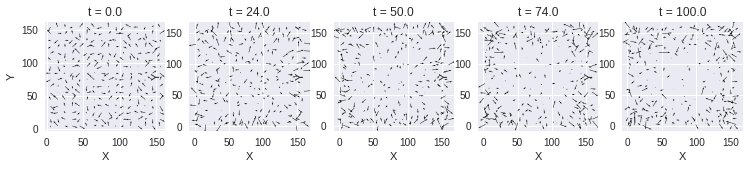

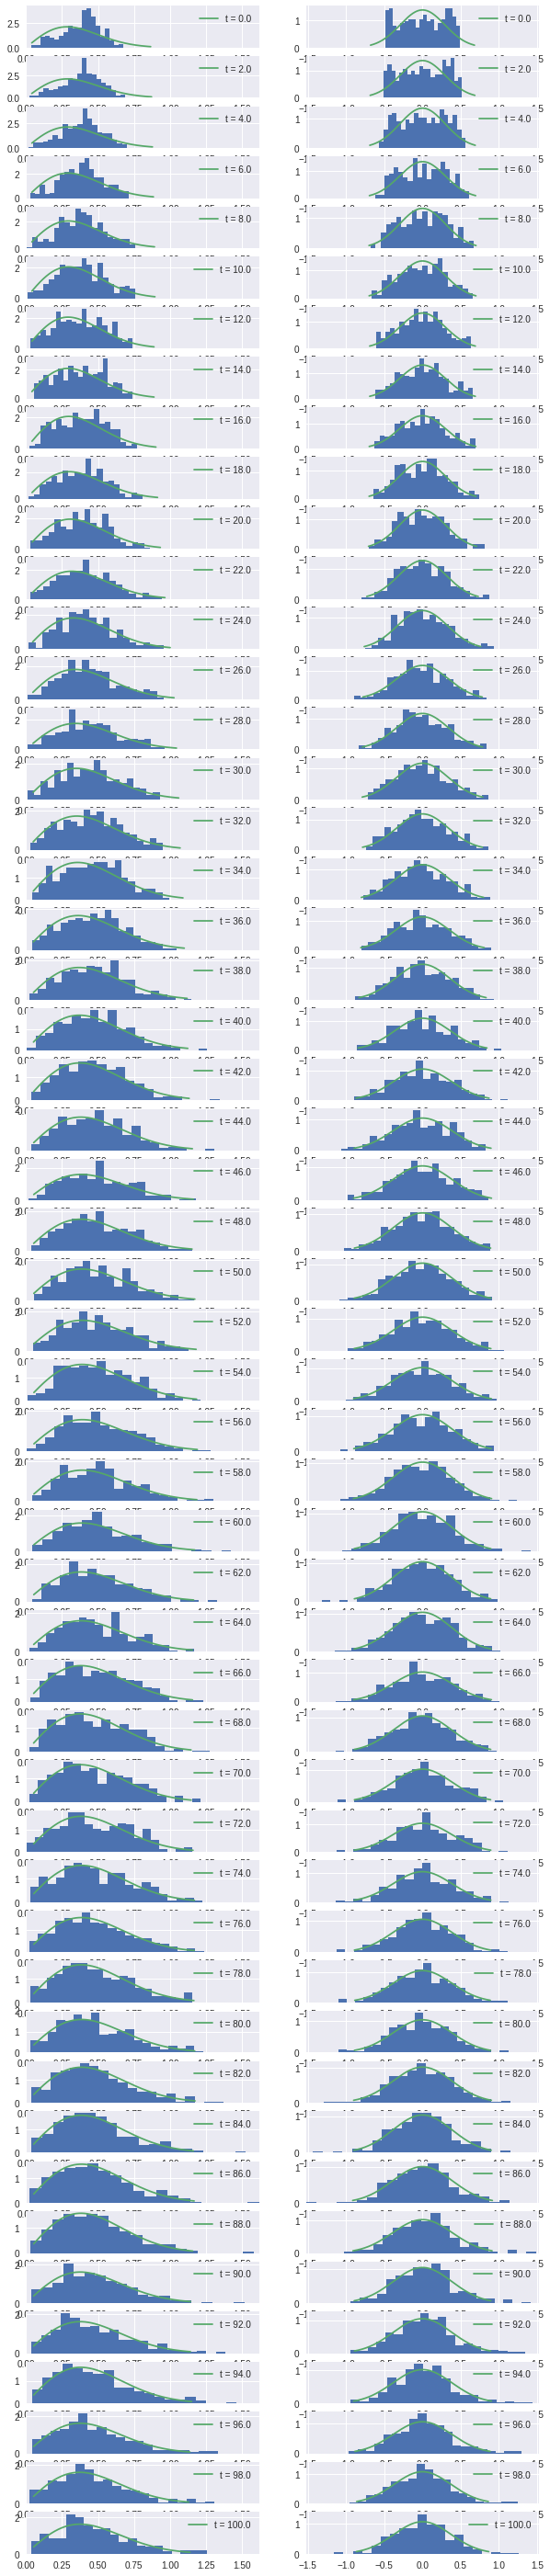

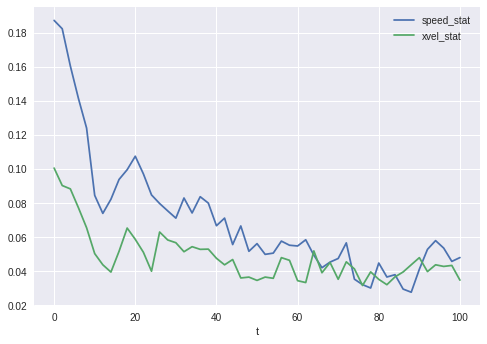

In [0]:
result = run_simulation(TaskGenerator(dt=0.1), NumbaSolver(), True, 16, 1000, 20)
fits = plot_and_fit(result)
q = fits.plot()

In [0]:
check(TaskGenerator(), NumbaSolver(), True)[0]

initial     final  improvement
speed_stat  0.159801  0.075140     2.126728
xvel_stat   0.085247  0.053948     1.580171

{'pos_t': 'float64', 'vel_t': 'float64', 'time_t': 'float64', 'mass_t': 'float64', 'charge_t': 'float64', 'compound': False, 'scalar': False, 'form': 'split', 'tpb': 64}

charge_t  compound                                               data  \
19  float32     False       t       time        perf  \
0    0   0.00...   
59  float32     False       t  time        perf                      ...   

    fit_speed  fit_xvel   form   mass_t    pos_t  scalar   time_t  tpb  \
19   0.087208  0.075510  split  float32  float32   False  float32   64   
59   0.124936  0.044124  split  float32  float64   False  float64   64   

      vel_t  
19  float32  
59  float64

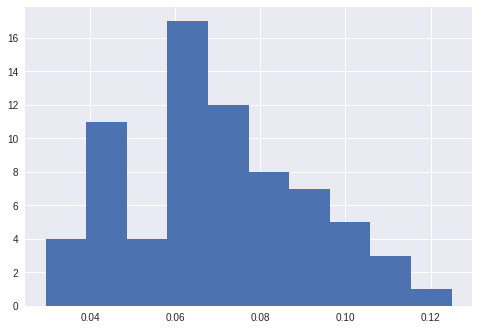

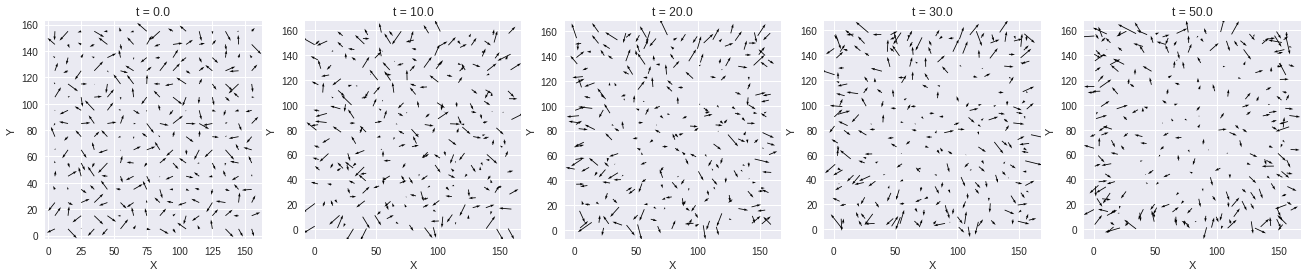

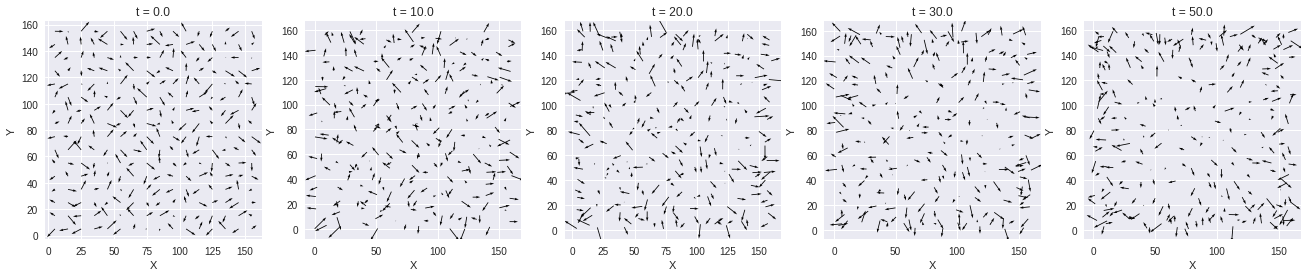

In [0]:
test_fits(NumbaSolver)

# CUDA

In [0]:
import pycuda.autoinit
import pycuda.driver as cuda
from pprint import pprint
from pycuda.compiler import SourceModule
(free,total)=cuda.mem_get_info()
print(free, total)
print( "Global memory occupancy: {}% free".format( free * 100 / total ) )

for devicenum in range( cuda.Device.count() ):
  device = cuda.Device( devicenum )
  attrs = device.get_attributes()
  pprint(attrs)


11922505728 11996954624
Global memory occupancy: 99.37943504553176% free
{pycuda._driver.device_attribute.MAX_THREADS_PER_BLOCK: 1024,
 pycuda._driver.device_attribute.MAX_BLOCK_DIM_X: 1024,
 pycuda._driver.device_attribute.MAX_BLOCK_DIM_Y: 1024,
 pycuda._driver.device_attribute.MAX_BLOCK_DIM_Z: 64,
 pycuda._driver.device_attribute.MAX_GRID_DIM_X: 2147483647,
 pycuda._driver.device_attribute.MAX_GRID_DIM_Y: 65535,
 pycuda._driver.device_attribute.MAX_GRID_DIM_Z: 65535,
 pycuda._driver.device_attribute.MAX_SHARED_MEMORY_PER_BLOCK: 49152,
 pycuda._driver.device_attribute.TOTAL_CONSTANT_MEMORY: 65536,
 pycuda._driver.device_attribute.WARP_SIZE: 32,
 pycuda._driver.device_attribute.MAX_PITCH: 2147483647,
 pycuda._driver.device_attribute.MAX_REGISTERS_PER_BLOCK: 65536,
 pycuda._driver.device_attribute.CLOCK_RATE: 823500,
 pycuda._driver.device_attribute.TEXTURE_ALIGNMENT: 512,
 pycuda._driver.device_attribute.GPU_OVERLAP: 1,
 pycuda._driver.device_attribute.MULTIPROCESSOR_COUNT: 13,
 pycuda

## Solver

In [0]:
import pycuda.driver as cuda

class CudaSolver(Solver):
  tpl = Template("""
typedef float float32;
typedef double float64;
typedef int int32;

{% set i_thread -%}
  int i = threadIdx.x + blockIdx.x*blockDim.x;
{% endset -%}

{%- if format == "split" %}
  {% set xi, yi, vxi, vyi = 'x[i]', 'y[i]', 'vx[i]', 'vy[i]' %}
  {% set xj, yj = 'x[j]', 'y[j]' %}
  {% set pos = pos_t + ' *x, ' + pos_t + ' *y' %}
  {% set vel = vel_t + ' *vx, ' + vel_t + ' *vy' %}
{% elif format == "nx" %}
  {% set xi, yi, vxi, vyi = 'pos[2*i]', 'pos[2*i+1]', 'vel[2*i]', 'vel[2*i+1]' %}  
  {% set xj, yj = 'pos[2*j]', 'pos[2*j+1]' %}
  {% set pos, vel = pos_t + ' *pos', vel_t + ' *vel' %}
{% elif format == "xn" %}
  {% set xi, yi, vxi, vyi = 'pos[i]', 'pos[n+i]', 'vel[i]', 'vel[n+i]' %}
  {% set xj, yj = 'pos[j]', 'pos[n+j]' %}
  {% set pos, vel = pos_t + ' *pos', vel_t + ' *vel' %}
{% endif -%}

{%- set update_v %}
  {{pos_t}} epsilon = 0.0001;
  {{pos_t}} diff0;
  {{pos_t}} diff1;
  {{pos_t}} dist;
  for(int j = 0; j<n; j++){
    if(i != j){
      diff0 = {{xj}} - {{xi}};
      diff1 = {{yj}} - {{yi}};
      dist = sqrt( diff0*diff0 + diff1*diff1 );
      diff0 = diff0 / dist;
      diff1 = diff1 / dist;
      dist = max(epsilon, dist);
      {{vxi}} += - q{% if not scalar %}[i]{% endif %} * q{% if not scalar %}[j]{% endif %} * diff0 / dist / dist / m{% if not scalar %}[i]{% endif %} * dt;
      {{vyi}} += - q{% if not scalar %}[i]{% endif %} * q{% if not scalar %}[j]{% endif %} * diff1 / dist / dist / m{% if not scalar %}[i]{% endif %} * dt;
    }   
  }
{% endset -%}

{%- set update_p %}
  {{xi}} += {{vxi}} * dt;
  {{yi}} += {{vyi}} * dt;
{% endset -%}

{%- set rebound %}
  if({{xi}} < 0){
    {{xi}} = - {{xi}};
    {{vxi}} = - {{vxi}};
  } else if ({{xi}} > size) {
    {{xi}} = 2*size - {{xi}};
    {{vxi}} = - {{vxi}};
  }
  if({{yi}} < 0){
    {{yi}} = - {{yi}};
    {{vyi}} = - {{vyi}};
  } else if ({{yi}} > size) {
    {{yi}} = 2*size - {{yi}};
    {{vyi}} = - {{vyi}};
  }
{% endset -%}

__global__ void update_v({{pos}}, {{vel}}, {{time_t}} dt,
                         {{charge_t}} {% if not scalar %}*{% endif %}q, 
                         {{mass_t}} {% if not scalar %}*{% endif %}m, int n){
  {{ i_thread}}
  if(i < n){
    {{ update_v }}
  }
}

__global__ void update_p({{pos}}, {{vel}}, {{time_t}} dt, int n){
  {{ i_thread }}
  if(i < n){
    {{ update_p }}
  }
}

__global__ void rebound({{pos}}, {{vel}}, {{pos_t}} size, int n){
  {{ i_thread }}
  if(i < n){
    {{ rebound }}
  }
}

__global__ void update({{pos}}, {{vel}}, {{time_t}} dt, {{pos_t}} size, 
                       {{charge_t}} {% if not scalar %}*{% endif %}q, 
                       {{mass_t}} {% if not scalar %}*{% endif %}m, int n){
  {{ i_thread }}
  if(i < n){
    {{ update_v }}
    {{ update_p }}
    {{ rebound }}
  }
}

""")

  def _to_device(self, host_array):
    return cuda.to_device(host_array)
  
  def _to_host(self, dev_array, host_array):
    return cuda.from_device_like(dev_array, host_array)
  
  def __init__(self, coord_format=CoordFormat.nx, scalar=False, threadsperblock=64, types={}):
    super().__init__(coord_format, scalar, threadsperblock, types)
    mod = SourceModule(self.source)
    self.update_v = mod.get_function("update_v")
    self.update_p = mod.get_function("update_p")
    self.rebound = mod.get_function("rebound")
    self.update = mod.get_function("update")
    
  def call(self, foo, *args, **kwargs):
    grid = (self.blockspergrid, 1)
    block = (self.threadsperblock, 1, 1)
    return foo(block=block, grid=grid, shared=0, *args, **kwargs)


##  Tests

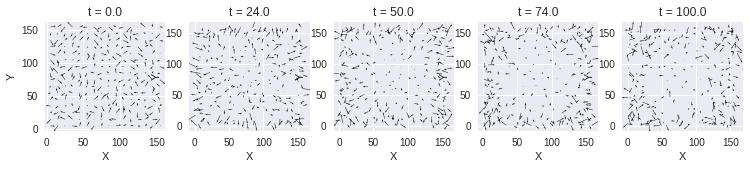

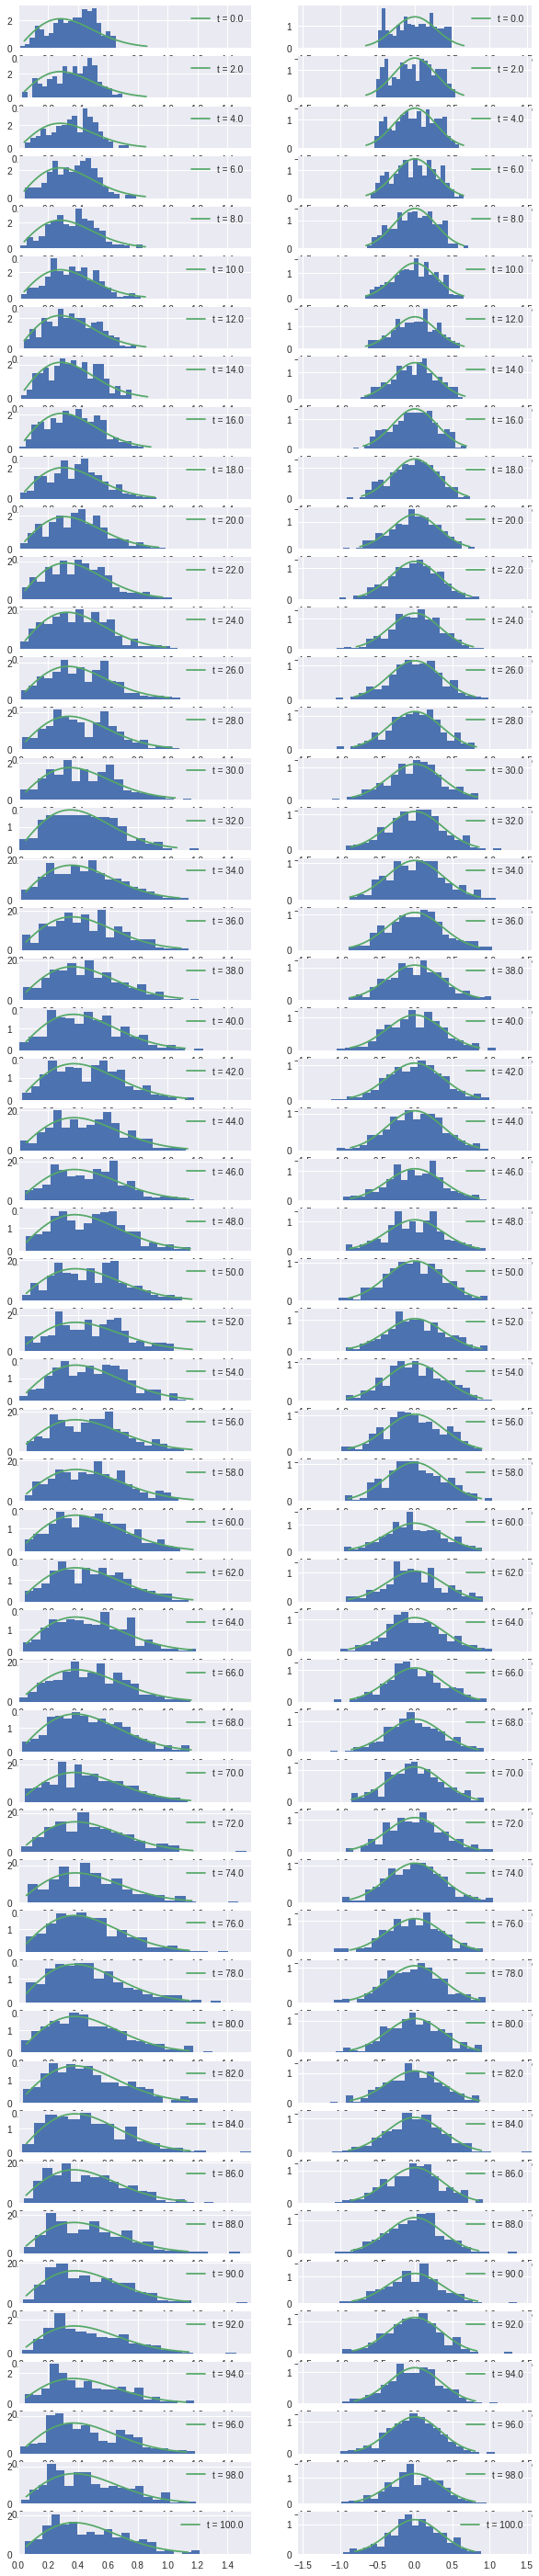

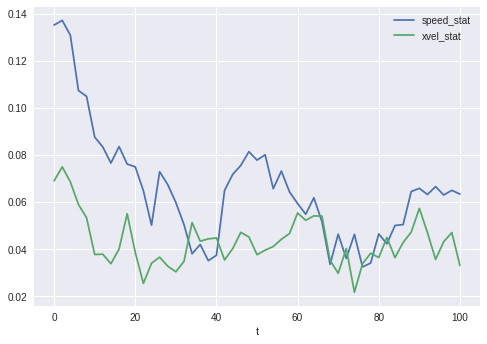

In [0]:
result = run_simulation(TaskGenerator(dt=0.1), CudaSolver(), True, 16, 1000, 20)
fits = plot_and_fit(result)
q = fits.plot()



In [0]:
check(TaskGenerator(), CudaSolver(), True)[0]

initial     final  improvement
speed_stat  0.153196  0.070821     2.163128
xvel_stat   0.087695  0.057509     1.524885

{'pos_t': 'float64', 'vel_t': 'float64', 'time_t': 'float64', 'mass_t': 'float64', 'charge_t': 'float64', 'compound': False, 'scalar': False, 'form': 'split', 'tpb': 64}

charge_t  compound                                               data  \
23  float32     False       t       time        perf  \
0    0   0.00...   
35  float64     False       t       time        perf  \
0    0   0.00...   

    fit_speed  fit_xvel   form   mass_t    pos_t  scalar   time_t  tpb  \
23   0.121871  0.046131  split  float32  float32   False  float32   64   
35   0.078020  0.086011  split  float64  float32   False  float32   64   

      vel_t  
23  float32  
35  float32

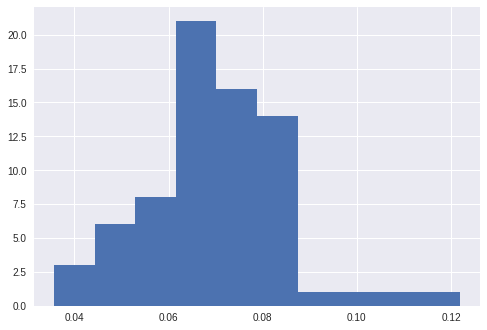

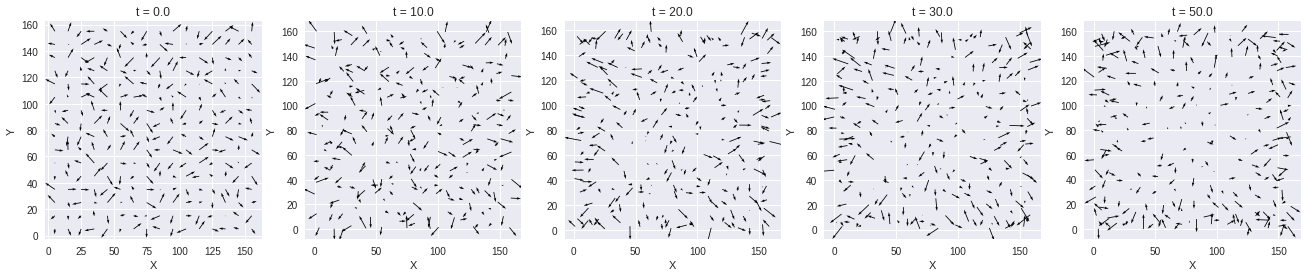

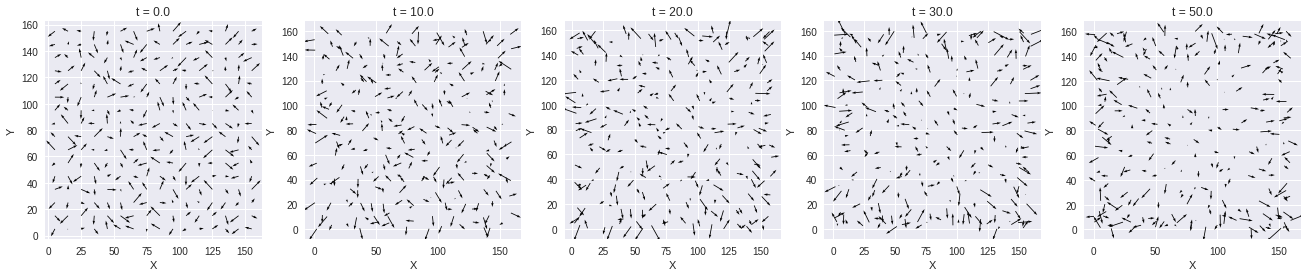

In [0]:
test_fits(CudaSolver)

# OpenCL

In [0]:
import pyopencl as cl  # Import the OpenCL GPU computing API
import pyopencl.array as cl_array

print('\n' + '=' * 60 + '\nOpenCL Platforms and Devices')
for platform in cl.get_platforms():  # Print each platform on this computer
    print('=' * 60)
    print('Platform - Name:  ' + platform.name)
    print('Platform - Vendor:  ' + platform.vendor)
    print('Platform - Version:  ' + platform.version)
    print('Platform - Profile:  ' + platform.profile)
    for device in platform.get_devices():  # Print each device per-platform
        print('    ' + '-' * 56)
        print('    Device - Name:  ' + device.name)
        print('    Device - Type:  ' + cl.device_type.to_string(device.type))
        print('    Device - Max Clock Speed:  {0} Mhz'.format(device.max_clock_frequency))
        print('    Device - Compute Units:  {0}'.format(device.max_compute_units))
        print('    Device - Local Memory:  {0:.0f} KB'.format(device.local_mem_size/1024))
        print('    Device - Constant Memory:  {0:.0f} KB'.format(device.max_constant_buffer_size/1024))
        print('    Device - Global Memory: {0:.0f} GB'.format(device.global_mem_size/1073741824.0))
print('\n')



OpenCL Platforms and Devices
Platform - Name:  NVIDIA CUDA
Platform - Vendor:  NVIDIA Corporation
Platform - Version:  OpenCL 1.2 CUDA 9.2.176
Platform - Profile:  FULL_PROFILE
    --------------------------------------------------------
    Device - Name:  Tesla K80
    Device - Type:  GPU
    Device - Max Clock Speed:  823 Mhz
    Device - Compute Units:  13
    Device - Local Memory:  48 KB
    Device - Constant Memory:  64 KB
    Device - Global Memory: 11 GB




## Solver

In [0]:
import pyopencl as cl
import pyopencl.array as cl_array


class OpenCLSolver(Solver):
  tpl = Template("""
typedef float float32;
typedef double float64;
typedef int int32;

{% set i_thread -%}
  int i = get_global_id(0);
{% endset -%}

{%- if format == "split" %}
  {% set xi, yi, vxi, vyi = 'x[i]', 'y[i]', 'vx[i]', 'vy[i]' %}
  {% set xj, yj = 'x[j]', 'y[j]' %}
  {% set pos = '__global ' + pos_t + ' *x, __global ' + pos_t + ' *y' %}
  {% set vel = '__global ' + vel_t + ' *vx, __global ' + vel_t + ' *vy' %}
{% elif format == "nx" %}
  {% set xi, yi, vxi, vyi = 'pos[2*i]', 'pos[2*i+1]', 'vel[2*i]', 'vel[2*i+1]' %}  
  {% set xj, yj = 'pos[2*j]', 'pos[2*j+1]' %}
  {% set pos, vel = '__global ' + pos_t + ' *pos', '__global ' + vel_t + ' *vel' %}
{% elif format == "xn" %}
  {% set xi, yi, vxi, vyi = 'pos[i]', 'pos[n+i]', 'vel[i]', 'vel[n+i]' %}
  {% set xj, yj = 'pos[j]', 'pos[n+j]' %}
  {% set pos, vel = '__global ' + pos_t + ' *pos', '__global ' + vel_t + ' *vel' %}
{% endif -%}

{%- set update_v %}
  {{pos_t}} epsilon = 0.0001;
  {{pos_t}} diff0;
  {{pos_t}} diff1;
  {{pos_t}} dist;
  for(int j = 0; j<n; j++){
    if(i != j){
      diff0 = {{xj}} - {{xi}};
      diff1 = {{yj}} - {{yi}};
      dist = sqrt(diff0*diff0 + diff1*diff1);
      diff0 = diff0 / dist;
      diff1 = diff1 / dist;
      dist = max(epsilon, dist);
      {{vxi}} += - q{% if not scalar %}[i]{% endif %} * q{% if not scalar %}[j]{% endif %} * diff0 / dist / dist / m{% if not scalar %}[i]{% endif %} * dt;
      {{vyi}} += - q{% if not scalar %}[i]{% endif %} * q{% if not scalar %}[j]{% endif %} * diff1 / dist / dist / m{% if not scalar %}[i]{% endif %} * dt;
    }   
  }
{% endset -%}

{%- set update_p %}
  {{xi}} += {{vxi}} * dt;
  {{yi}} += {{vyi}} * dt;
{% endset -%}

{%- set rebound %}
  if({{xi}} < 0){
    {{xi}} = - {{xi}};
    {{vxi}} = - {{vxi}};
  } else if ({{xi}} > size) {
    {{xi}} = 2*size - {{xi}};
    {{vxi}} = - {{vxi}};
  }
  if({{yi}} < 0){
    {{yi}} = - {{yi}};
    {{vyi}} = - {{vyi}};
  } else if ({{yi}} > size) {
    {{yi}} = 2*size - {{yi}};
    {{vyi}} = - {{vyi}};
  }
{% endset -%}

__kernel void update_v({{pos}}, {{vel}}, {{time_t}} dt,
                         {% if not scalar %}__global{% endif %} {{charge_t}} {% if not scalar %}*{% endif %}q, 
                         {% if not scalar %}__global{% endif %} {{mass_t}} {% if not scalar %}*{% endif %}m, int n){
  {{ i_thread}}
  if(i < n){
    {{ update_v }}
  }
}

__kernel void update_p({{pos}}, {{vel}}, {{time_t}} dt, int n){
  {{ i_thread }}
  if(i < n){
    {{ update_p }}
  }
}

__kernel void rebound({{pos}}, {{vel}}, {{pos_t}} size, int n){
  {{ i_thread }}
  if(i < n){
    {{ rebound }}
  }
}

__kernel void update({{pos}}, {{vel}}, {{time_t}} dt, {{pos_t}} size, 
                       {% if not scalar %}__global{% endif %} {{charge_t}} {% if not scalar %}*{% endif %}q, 
                       {% if not scalar %}__global{% endif %} {{mass_t}} {% if not scalar %}*{% endif %}m, int n){
  {{ i_thread }}
  if(i < n){
    {{ update_v }}
    {{ update_p }}
    {{ rebound }}
  }
}

""")
  
  def _to_device(self, host_array):
    return cl_array.to_device(self.queue, host_array)
  
  def _to_host(self, dev_array, host_array):
    return dev_array.get()
  
  def __init__(self, coord_format=CoordFormat.nx, scalar=False, threadsperblock=64, types={}):
    super().__init__(coord_format, scalar, threadsperblock, types)
    platform = cl.get_platforms()[0]
    my_gpu_devices = platform.get_devices(device_type=cl.device_type.GPU)
    if not my_gpu_devices:
        print("Warning: no GPU devices found!")
        print("Falling back to platform[0].device[0]")
        device = platform.get_devices()[0]
    else:
        device = my_gpu_devices[0]
    self.ctx = cl.Context([device])
    self.queue = cl.CommandQueue(self.ctx)
    program = cl.Program(self.ctx, self.source).build()
    q_t, m_t = (self.types["charge_t"], self.types["mass_t"]) if scalar else (None, None)
    arr_n = 4 if coord_format == CoordFormat.split else 2
    self.update_v = program.update_v
    self.update_v.set_scalar_arg_dtypes([None]*arr_n + [self.types['time_t'], q_t, m_t, np.int32 ] )
    self.update_p = program.update_p
    self.update_p.set_scalar_arg_dtypes([None]*arr_n + [self.types['time_t'], np.int32])
    self.rebound = program.rebound
    self.rebound.set_scalar_arg_dtypes([None]*arr_n + [self.types['pos_t'], np.int32 ])
    self.update = program.update
    self.update.set_scalar_arg_dtypes([None]*arr_n + [self.types['time_t'], self.types['pos_t'],
                                                      q_t, m_t, np.int32 ])
    

  def call(self, foo, *args, **kwargs):
    global_work = [self.blockspergrid * self.threadsperblock]
    local_work = [self.threadsperblock]
    args = [a.data if isinstance(a, cl_array.Array) else a for a in args]
    kwargs = {k: a.data if isinstance(a, cl_array.Array) else a for k, a in kwargs.items()}
    return foo(self.queue, global_work, local_work, *args, **kwargs)


## Tests

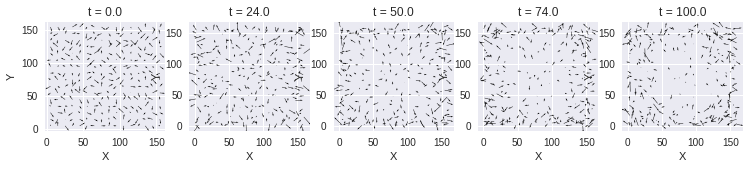

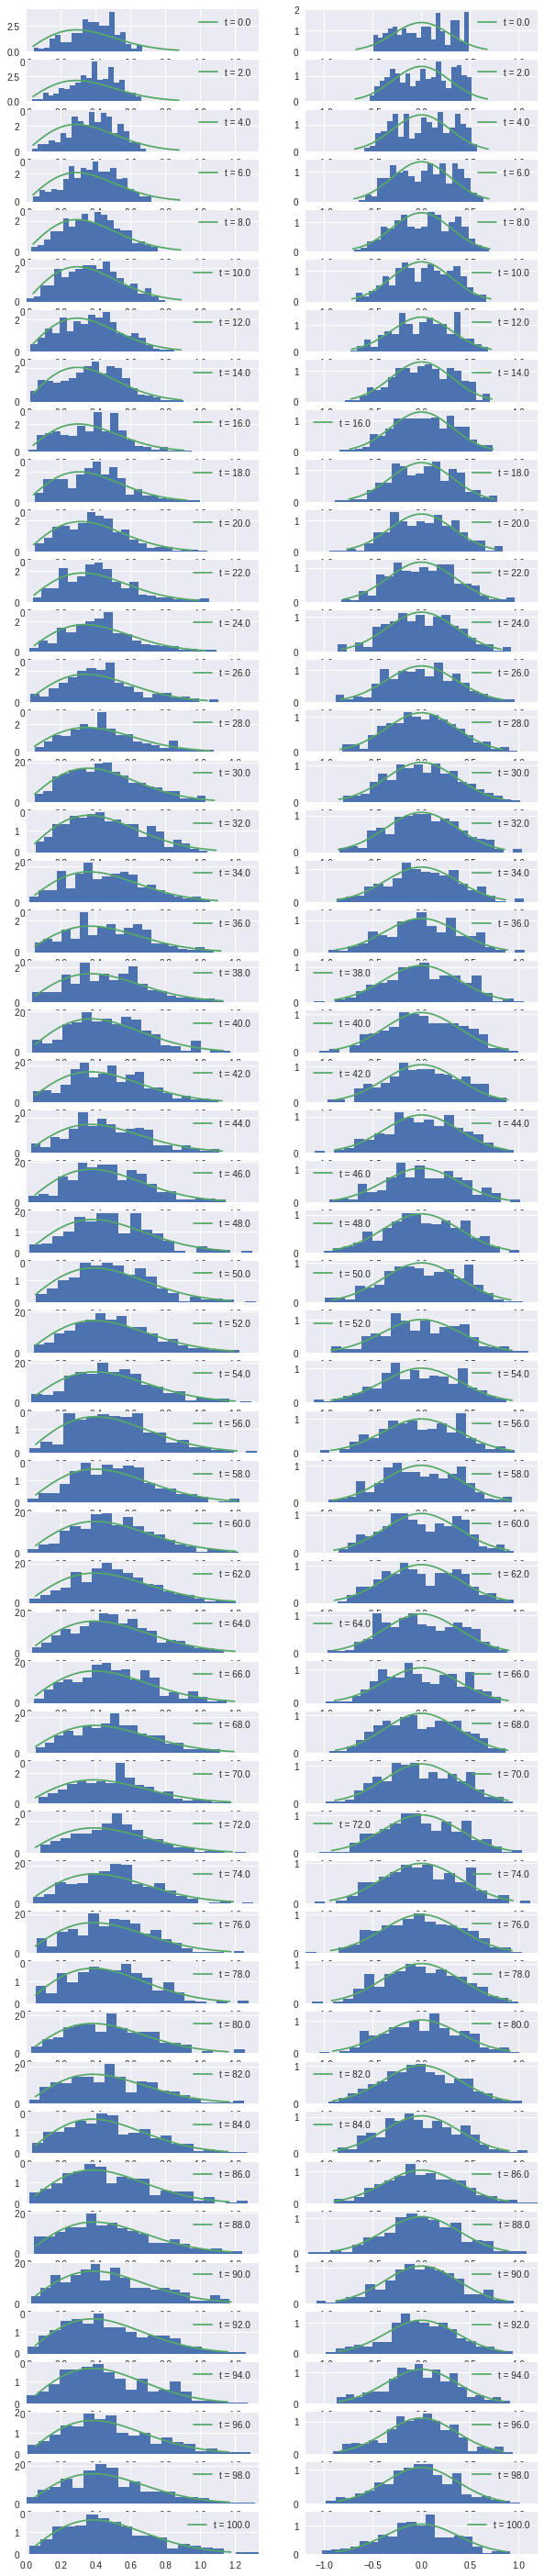

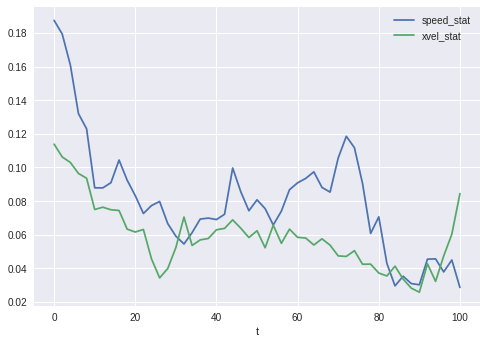

In [0]:
result = run_simulation(TaskGenerator(dt=0.1), OpenCLSolver(), True, 16, 1000, 20)
fits = plot_and_fit(result)
q = fits.plot()


In [0]:
check(TaskGenerator(), OpenCLSolver(), True)[0]

initial     final  improvement
speed_stat  0.179502  0.074745     2.401509
xvel_stat   0.084365  0.055681     1.515154

{'pos_t': 'float64', 'vel_t': 'float64', 'time_t': 'float64', 'mass_t': 'float64', 'charge_t': 'float64', 'compound': False, 'scalar': False, 'form': 'split', 'tpb': 64}

charge_t  compound                                               data  \
15  float32     False       t       time        perf  \
0    0   0.00...   
24  float64     False       t       time        perf  \
0    0   0.00...   

    fit_speed  fit_xvel   form   mass_t    pos_t  scalar   time_t  tpb  \
15   0.093846  0.085816  split  float32  float32   False  float32   64   
24   0.117016  0.069161  split  float64  float32   False  float32   64   

      vel_t  
15  float32  
24  float32

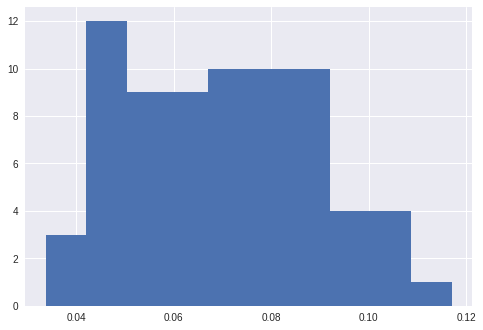

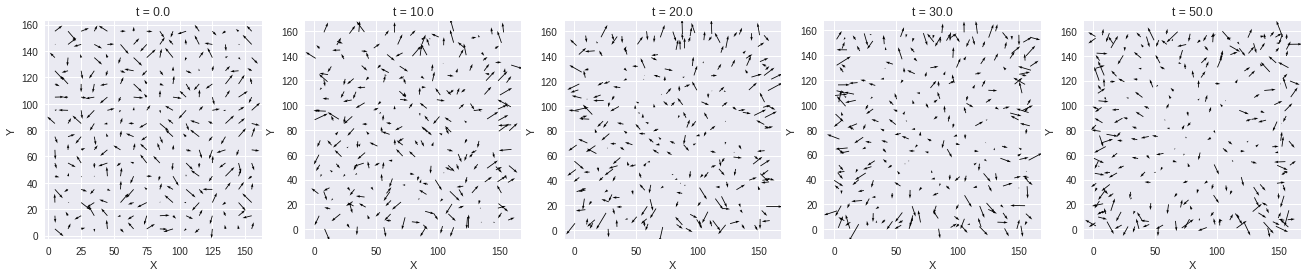

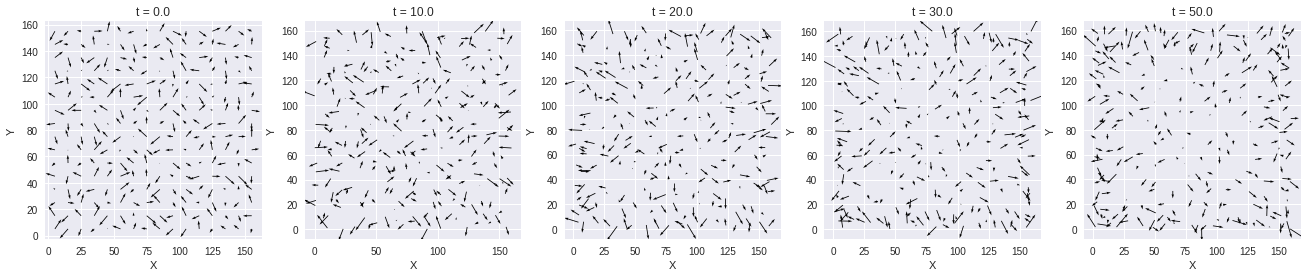

In [0]:
test_fits(OpenCLSolver)

# Numpy

## Solver

In [0]:
class NumpySolver(Solver):
  perf_good_batch_crits = (6, 8)
  no_blocks = True
  tpl = Template("""
{% if format == "split" %}
{% set pos = 'x, y'%}
{% set vel = 'vx, vy' %}
{%- set update_p %}
    x += vx*dt
    y += vy*dt
{% endset -%}
{%- set rebound %}
    below_zero = x < 0
    x[below_zero] = -x[below_zero]
    vx[below_zero] = -vx[below_zero]
    above_size = x > size
    x[above_size] = 2*size - x[above_size]
    vx[above_size] = -vx[above_size]
    below_zero = y < 0
    y[below_zero] = -y[below_zero]
    vy[below_zero] = -vy[below_zero]
    above_size = y > size
    y[above_size] = 2*size - y[above_size]
    vy[above_size] = -vy[above_size]
{% endset -%}
{% else -%}
{% set pos, vel = 'p', 'v' %}
{%- set update_p %}
    p += v*dt
{% endset -%}
{%- set rebound %}
    below_zero = p < 0
    p[below_zero] = -p[below_zero]
    v[below_zero] = -v[below_zero]
    above_size = p > size
    p[above_size] = 2*size - p[above_size]
    v[above_size] = -v[above_size]
{% endset -%}
{% endif -%}

{%- if format == "split" %}
{%- set update_v %}
    epsilon = np.{{pos_t}}(0.0001)
    dx, dy = x[np.newaxis] - x[:, np.newaxis], y[np.newaxis] - y[:, np.newaxis] # pairwise distance vectors
    dist = np.sqrt(dx*dx + dy*dy) # absolute distances
    np.fill_diagonal(dist, 1.0)
    dx = dx / dist # normalized distance vectors
    dy = dy / dist # normalized distance vectors
    dist = np.maximum(epsilon, dist)
    {% if scalar -%}
    fx = (q*q) * dx / (dist**2)
    fy = (q*q) * dy / (dist**2)
    {% else -%}
    fx = q[:, np.newaxis] * q[np.newaxis, :] * dx / (dist**2)
    fy = q[:, np.newaxis] * q[np.newaxis, :] * dy / (dist**2)
    {% endif -%}
    vx -= fx.sum(1)/m * dt
    vy -= fy.sum(1)/m * dt
{% endset -%}
{% elif format == "nx" %}
{%- set update_v %}
    epsilon = np.{{pos_t}}(0.0001)
    diff = p[np.newaxis] - p[:, np.newaxis] # pairwise distance vectors
    dist = np.sqrt((diff*diff).sum(2)) # absolute distances
    np.fill_diagonal(dist, 1.0)
    diff = diff / dist[:, :, np.newaxis] # normalized distance vectors
    dist = np.maximum(epsilon, dist)
    {% if scalar -%}
    f = q*q * diff / (dist**2)[:, :, np.newaxis]
    v -= f.sum(1) / m * dt
    {% else -%}
    f = q[:, np.newaxis, np.newaxis] * q[np.newaxis, :, np.newaxis] * diff / (dist**2)[:, :, np.newaxis]
    v -= f.sum(1) / m[:, np.newaxis] * dt
    {% endif -%}
{% endset -%}
{% elif format == "xn" %}
{%- set update_v %}
    epsilon = np.{{pos_t}}(0.0001)
    diff = p[:, np.newaxis] - p[:, :, np.newaxis] # pairwise distance vectors
    dist = np.sqrt((diff*diff).sum(0)) # absolute distances
    np.fill_diagonal(dist, 1.0)
    diff = diff / dist # normalized distance vectors
    dist = np.maximum(epsilon, dist)
    {% if scalar -%}
    f = q*q * diff / (dist**2)
    {% else -%}
    f = q[np.newaxis, :, np.newaxis] * q[np.newaxis, np.newaxis, :] * diff / (dist**2)
    {% endif -%}
    v -= f.sum(2)/m * dt
{% endset -%}
{% endif -%}

def update_v({{pos}}, {{vel}}, dt, q, m, n):
{{ update_v }}

def update_p({{pos}}, {{vel}}, dt, n):
{{ update_p }}

def rebound({{pos}}, {{vel}}, size, n):
{{ rebound }}

def update({{pos}}, {{vel}}, dt, size, q, m, n):
{{ update_v }}
{{ update_p }}
{{ rebound }}

""")
  
  def __init__(self, coord_format=CoordFormat.xn, scalar=False, threadsperblock=64, types={}):
    super().__init__(coord_format, scalar, threadsperblock, types)
    context = {"np": np}
    exec(self.source, context)
    self.update_v = context['update_v']
    self.update_p = context['update_p']
    self.rebound = context['rebound']
    self.update = context['update']


## Tests

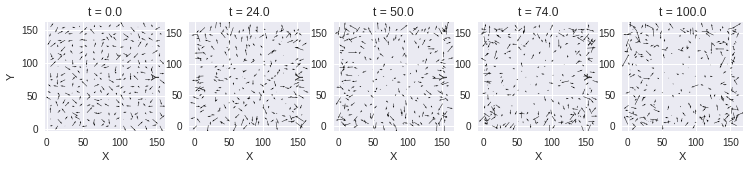

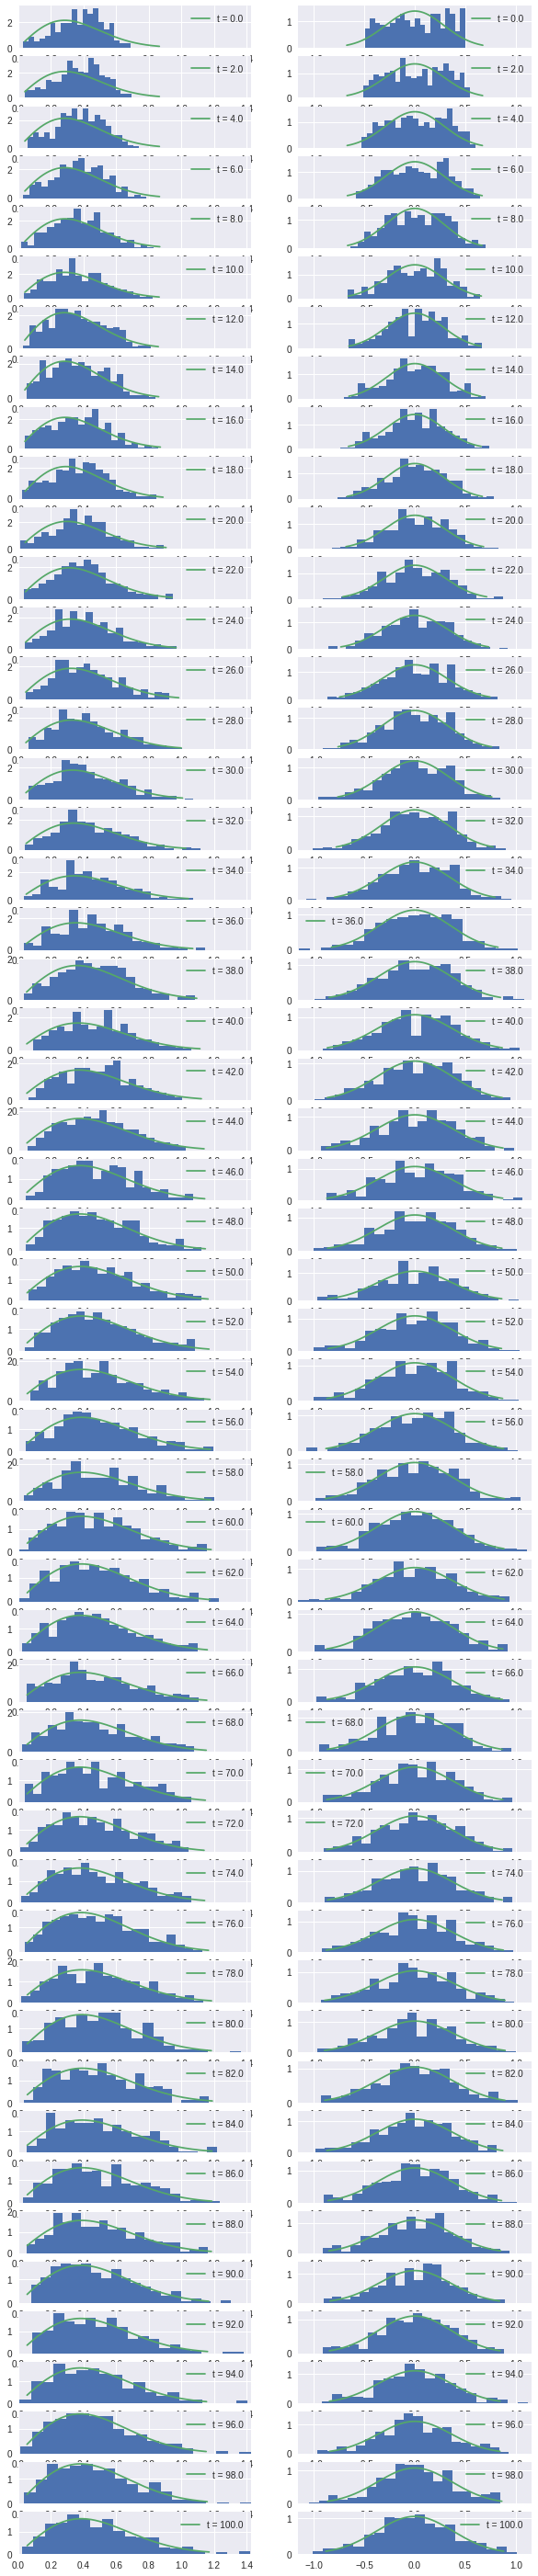

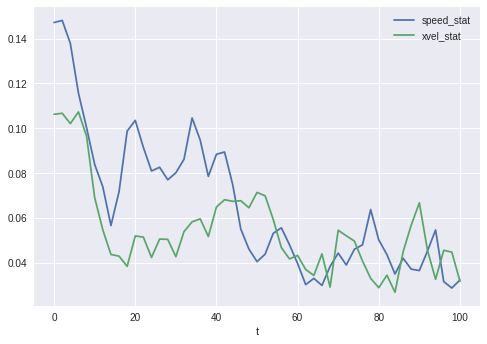

In [0]:
result = run_simulation(TaskGenerator(dt=0.1), NumpySolver(), True, 16, 1000, 20)
fits = plot_and_fit(result)
q = fits.plot()

In [0]:
check(TaskGenerator(), NumpySolver(), True)[0]

initial     final  improvement
speed_stat  0.133327  0.081206     1.641841
xvel_stat   0.102429  0.049955     2.050421

{'pos_t': 'float64', 'vel_t': 'float64', 'time_t': 'float64', 'mass_t': 'float64', 'charge_t': 'float64', 'compound': False, 'scalar': False, 'form': 'split', 'tpb': 1}

charge_t  compound                                               data  \
22  float32     False       t       time        perf  \
0    0   0.00...   
32  float64     False       t       time        perf  \
0    0   0.00...   

    fit_speed  fit_xvel   form   mass_t    pos_t  scalar   time_t  tpb  \
22   0.051722  0.082273  split  float32  float32   False  float32    1   
32   0.107848  0.057013  split  float64  float32   False  float32    1   

      vel_t  
22  float32  
32  float32

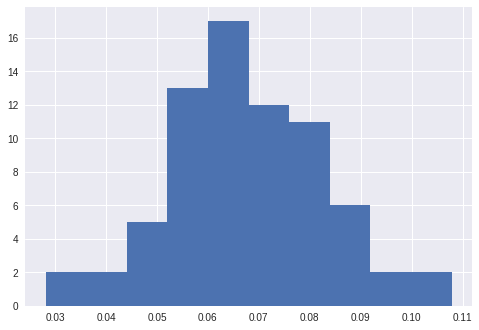

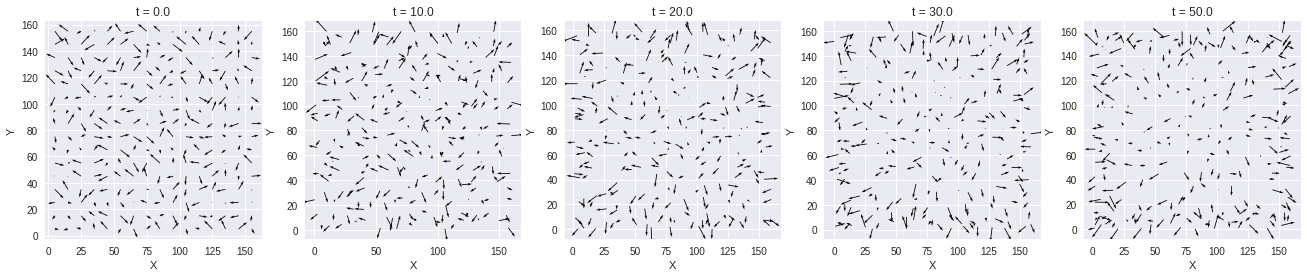

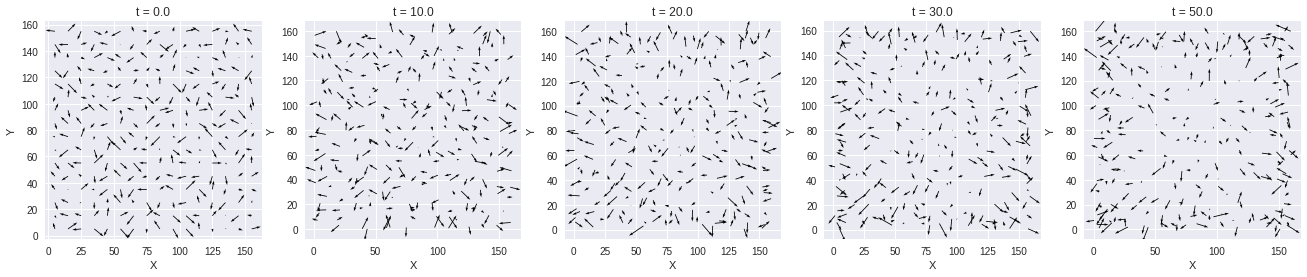

In [0]:
test_fits(NumpySolver)

# Extra CPU solvers

In [0]:
import numpy as np
from numba import jit

## compound split scalar only

@jit(nopython=True, parallel=True)
def update_v(x, y, vx, vy, dt, q, m, n):
  epsilon = np.float32(0.0001)
  for i in range(n):
    dx = x - x[i]
    dy = y - y[i]
    dist = np.sqrt(dx*dx + dy*dy) # absolute distances
    dist[i] = 1.0
    dx = dx / dist # normalized distance
    dy = dy / dist
    dist = np.maximum(epsilon, dist)
    fx = (q*q) * dx / (dist**2)
    fy = (q*q) * dy / (dist**2)
    vx[i] -= fx.sum()/m * dt
    vy[i] -= fy.sum()/m * dt

@jit(nopython=True, parallel=True)
def update_p(x, y, vx, vy, dt, n):
  x += vx*dt
  y += vy*dt

@jit(nopython=True, parallel=True)
def rebound(x, y, vx, vy, size, n):
  below_zero = x < 0
  x[below_zero] = -x[below_zero]
  vx[below_zero] = -vx[below_zero]
  above_size = x > size
  x[above_size] = 2*size - x[above_size]
  vx[above_size] = -vx[above_size]
  below_zero = y < 0
  y[below_zero] = -y[below_zero]
  vy[below_zero] = -vy[below_zero]
  above_size = y > size
  y[above_size] = 2*size - y[above_size]
  vy[above_size] = -vy[above_size]

class NumbaJitSolver(NumpySolver):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.update_v = update_v
    self.update_p = update_p
    self.rebound = rebound

class PythonSolver(NumpySolver):
  perf_good_batch_crits = (2, 2)
  tpl = Template("""
from math import sqrt
import numpy as np

{% set i_thread %}
  for i in range(n):
{% endset -%}

{%- if format == "split" %}
  {% set xi, yi, vxi, vyi = 'x[i]', 'y[i]', 'vx[i]', 'vy[i]' %}
  {% set xj, yj = 'x[j]', 'y[j]' %}
  {% set pos = 'x, y'%}
  {% set vel = 'vx, vy' %}
{% elif format == "nx" %}
  {% set xi, yi, vxi, vyi = 'pos[i, 0]', 'pos[i, 1]', 'vel[i, 0]', 'vel[i, 1]' %}  
  {% set xj, yj = 'pos[j, 0]', 'pos[j, 1]' %}
  {% set pos, vel = 'pos', 'vel' %}
{% elif format == "xn" %}
  {% set xi, yi, vxi, vyi = 'pos[0, i]', 'pos[1, i]', 'vel[0, i]', 'vel[1, i]' %}
  {% set xj, yj = 'pos[0, j]', 'pos[1, j]' %}
  {% set pos, vel = 'pos', 'vel' %}
{% endif -%}

{%- set update_v %}
    epsilon = np.{{pos_t}}(0.0001);
    for j in range(n):
      if i != j:
        diff0 = {{xj}} - {{xi}}
        diff1 = {{yj}} - {{yi}}
        dist = sqrt( diff0*diff0 + diff1*diff1 )
        diff0 = diff0 / dist
        diff1 = diff1 / dist
        dist = max(epsilon, dist)
        {{vxi}} += - q{% if not scalar %}[i]{% endif %} * q{% if not scalar %}[j]{% endif %} * diff0 / dist / dist / m{% if not scalar %}[i]{% endif %} * dt
        {{vyi}} += - q{% if not scalar %}[i]{% endif %} * q{% if not scalar %}[j]{% endif %} * diff1 / dist / dist / m{% if not scalar %}[i]{% endif %} * dt
{% endset -%}

{%- set update_p %}
    {{xi}} += {{vxi}} * dt
    {{yi}} += {{vyi}} * dt
{% endset -%}

{%- set rebound %}
    if {{xi}} < 0:
      {{xi}} = - {{xi}}
      {{vxi}} = - {{vxi}}
    elif {{xi}} > size:
      {{xi}} = 2*size - {{xi}}
      {{vxi}} = - {{vxi}}
    if {{yi}} < 0:
      {{yi}} = - {{yi}}
      {{vyi}} = - {{vyi}}
    elif {{yi}} > size:
      {{yi}} = 2*size - {{yi}}
      {{vyi}} = - {{vyi}}
{% endset -%}

def update_v({{pos}}, {{vel}}, dt, q, m, n):
{{ i_thread}}
{{ update_v }}

def update_p({{pos}}, {{vel}}, dt, n):
{{ i_thread }}
{{ update_p }}

def rebound({{pos}}, {{vel}}, size, n):
{{ i_thread }}
{{ rebound }}

def update({{pos}}, {{vel}}, dt, size, q, m, n):
{{ i_thread }}
{{ update_v }}
{{ update_p }}
{{ rebound }}
""")
  


## Tests

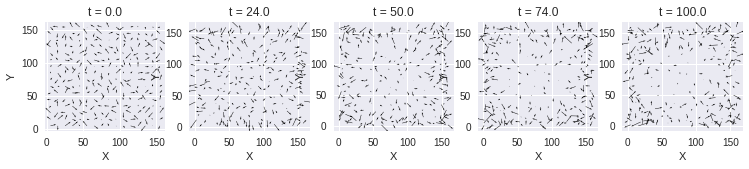

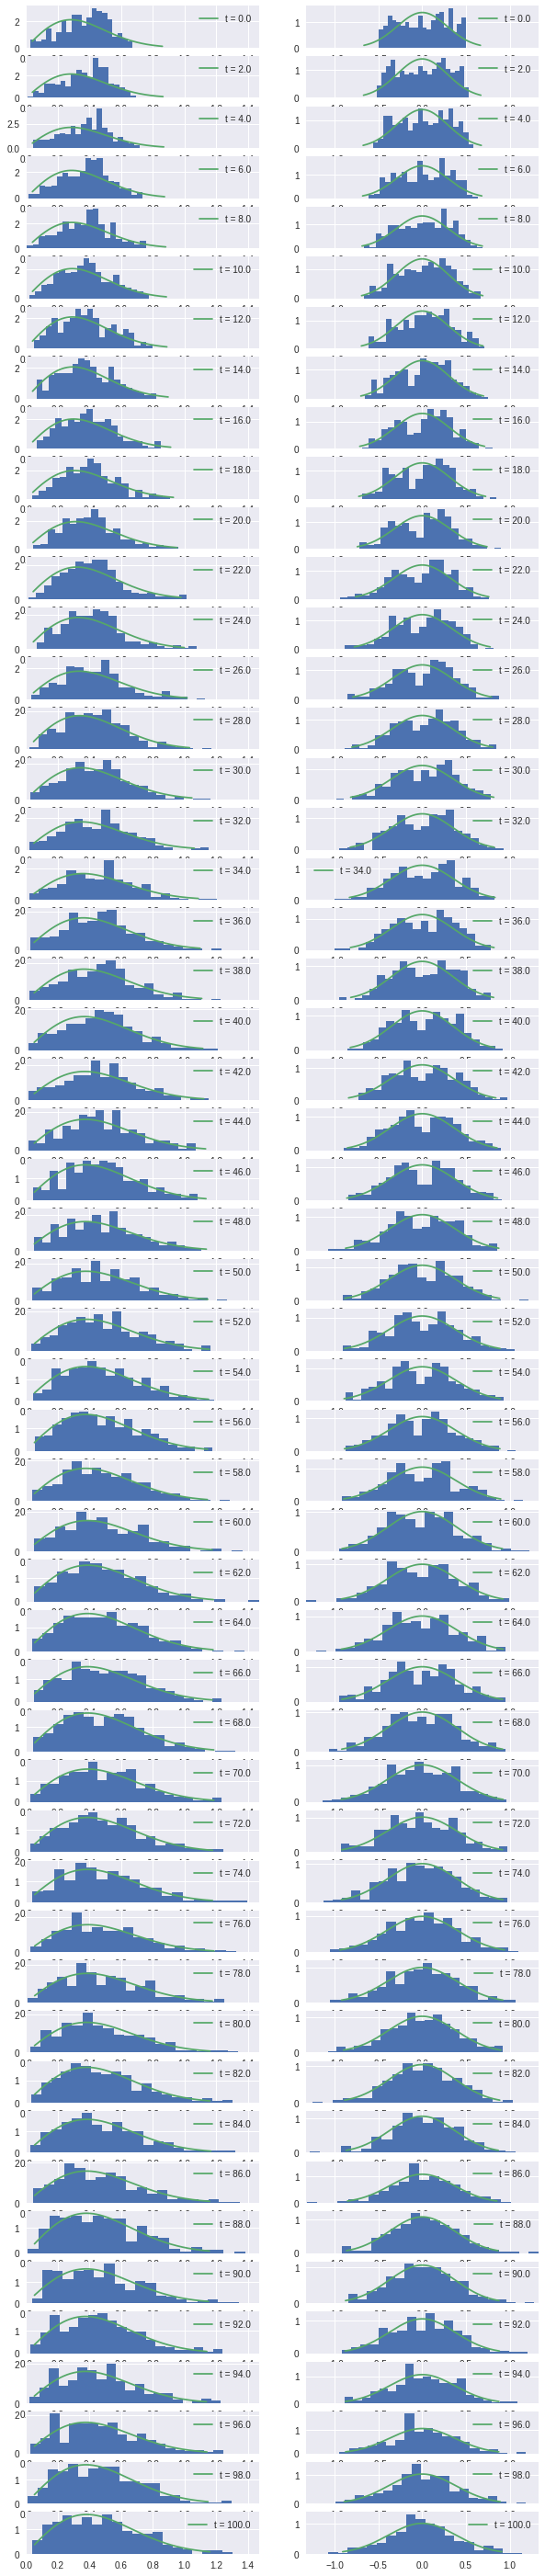

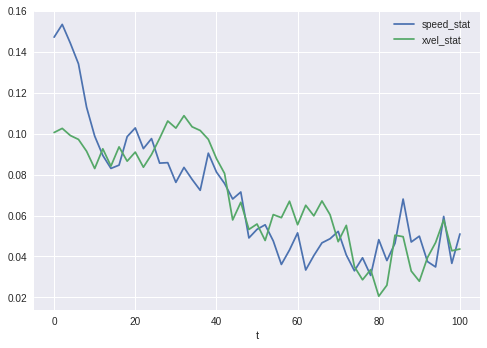

In [0]:
result = run_simulation(TaskGenerator(dt=0.1, scalar=True), NumbaJitSolver(coord_format=CoordFormat.split, scalar=True), True, 16, 1000, 20)
fits = plot_and_fit(result)
q = fits.plot()

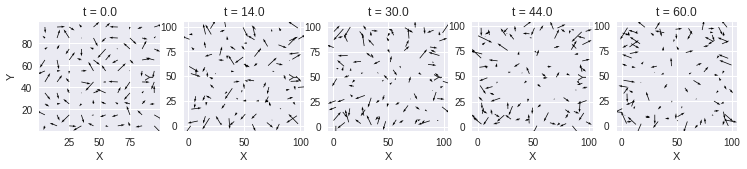

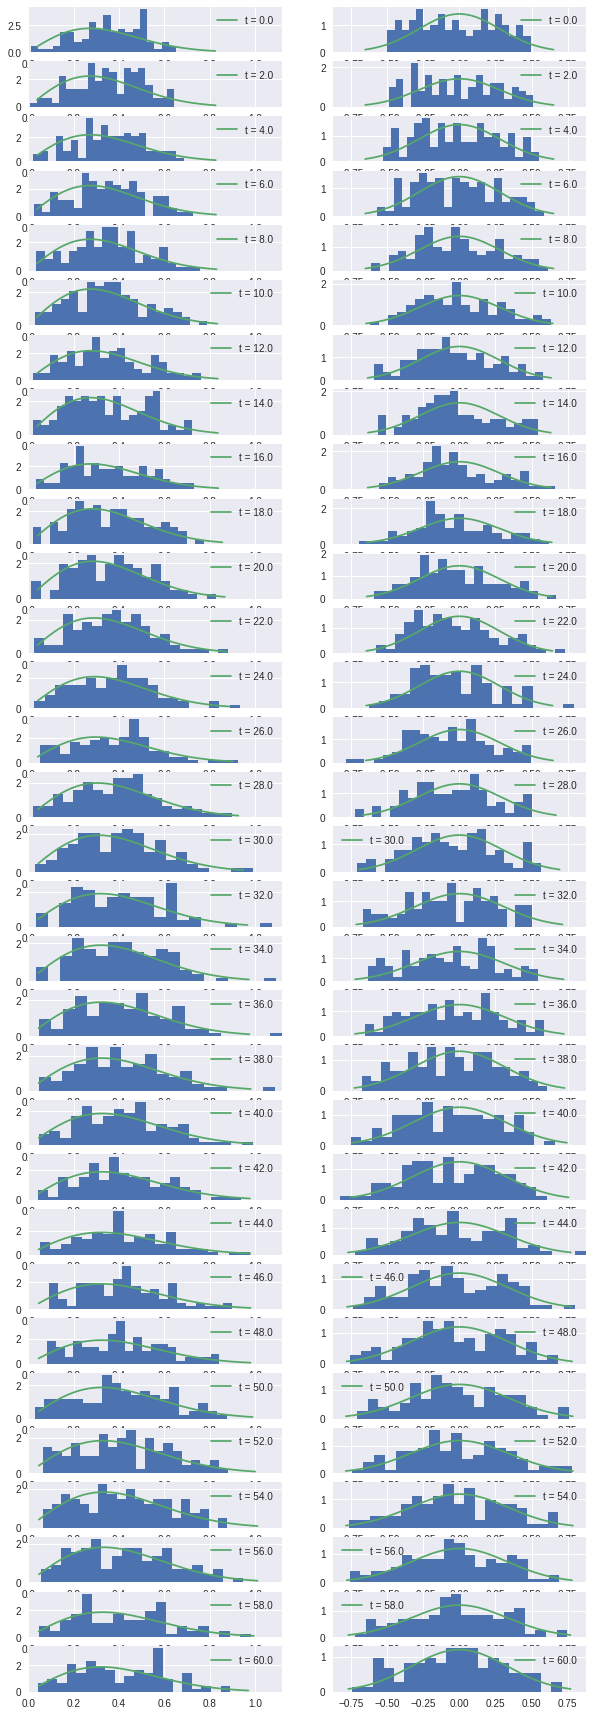

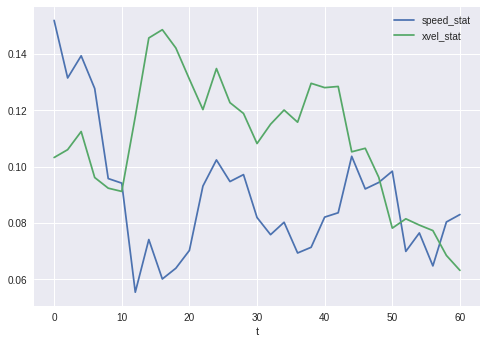

In [0]:
result = run_simulation(TaskGenerator(dt=0.1), PythonSolver(), True, 10, 600, 20)
fits = plot_and_fit(result)
q = fits.plot()

In [0]:
check(TaskGenerator(), PythonSolver(), True, scale=10, time_steps=600, save_step=600)[0]

initial     final  improvement
speed_stat  0.116866  0.093750     1.246563
xvel_stat   0.124206  0.054826     2.265440

{'pos_t': 'float64', 'vel_t': 'float64', 'time_t': 'float64', 'mass_t': 'float64', 'charge_t': 'float64', 'compound': False, 'scalar': False, 'form': 'split', 'tpb': 1}

charge_t  compound                                               data  \
3    int32     False       t       time         perf  \
0    0   0.0...   
9    int32     False       t       time         perf  \
0    0   0.0...   

   fit_speed  fit_xvel   form mass_t    pos_t  scalar   time_t  tpb    vel_t  
3   0.074323  0.166142  split  int32  float32   False  float32    1  float32  
9   0.161547  0.078628  split  int32  float32   False  float32    1  float32

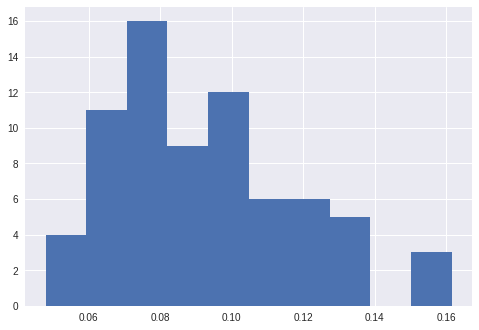

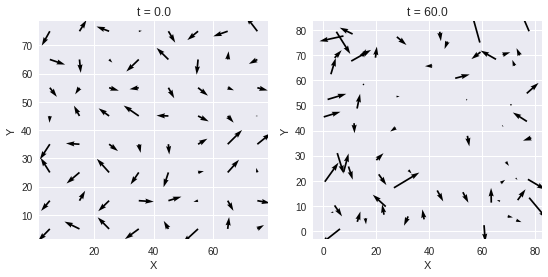

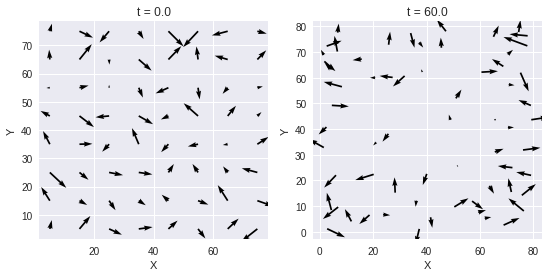

In [0]:
test_fits(PythonSolver, scale=8, time_steps=600, save_step=600)

# performance test

In [0]:
GPU_solvers = [NumbaSolver, CudaSolver, OpenCLSolver]
CPU_solvers = [NumpySolver, PythonSolver]
limited_solvers = [NumbaJitSolver]

In [0]:
from google.colab import drive
drive.mount("/drive")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


## ThreadsPerBlock

In [0]:
raw = list(benchmark_all(GPU_solvers, tpbs=many_tbps))

NumbaSolver
{'pos_t': 'float32', 'vel_t': 'float32', 'time_t': 'float32', 'mass_t': 'float32', 'charge_t': 'float32'}
{'compound': True, 'scalar': False, 'form': 'nx', 'tpb': 8}
1,8192.00: 9.10 2,8192.00: 8.49 4,8192.00: 8.61 8,8192.00: 8.75 16,8192.00: 9.13 32,4608.00: 19.45 64,1152.00: 55.74 128,72.00: 47.00 256,4.50: 51.79 {'compound': True, 'scalar': False, 'form': 'nx', 'tpb': 16}
1,8192.00: 8.54 2,8192.00: 8.66 4,8192.00: 8.66 8,8192.00: 8.58 16,8192.00: 9.14 32,4608.00: 19.31 64,1152.00: 37.20 128,72.00: 23.93 256,4.50: 26.59 {'compound': True, 'scalar': False, 'form': 'nx', 'tpb': 32}
1,8192.00: 8.65 2,8192.00: 8.79 4,8192.00: 8.55 8,8192.00: 8.61 16,8192.00: 9.70 32,4608.00: 19.95 64,1152.00: 20.26 128,72.00: 15.24 256,4.50: 14.33 {'compound': True, 'scalar': False, 'form': 'nx', 'tpb': 48}
1,8192.00: 8.56 2,8192.00: 8.76 4,8192.00: 8.60 8,8192.00: 8.49 16,8192.00: 9.86 32,4608.00: 20.51 64,1152.00: 21.11 128,72.00: 10.95 256,4.50: 10.73 {'compound': True, 'scalar': False, 'fo

In [0]:
tpb_times = process_perf(raw)
tpb_times.to_csv("/drive/My Drive/tpb.csv")
tpb_times

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


batch charge_t  compound form   mass_t      n    pos_t  scalar  \
0     8192  float32      True   nx  float32      1  float32   False   
1     8192  float32      True   nx  float32      4  float32   False   
2     8192  float32      True   nx  float32     16  float32   False   
3     8192  float32      True   nx  float32     64  float32   False   
4     8192  float32      True   nx  float32    256  float32   False   
5     4608  float32      True   nx  float32   1024  float32   False   
6     1152  float32      True   nx  float32   4096  float32   False   
7       72  float32      True   nx  float32  16384  float32   False   
8        5  float32      True   nx  float32  65536  float32   False   
9     8192  float32      True   nx  float32      1  float32   False   
10    8192  float32      True   nx  float32      4  float32   False   
11    8192  float32      True   nx  float32     16  float32   False   
12    8192  float32      True   nx  float32     64  float32   False   
13    8192  float32      True   nx  float32    256  float32   False   
14    4608  float32      True   nx  float32   1024  float32   False   
15    1152  float32      True   nx  float32   4096  float32   False   
16      72  float32      True   nx  float32  16384  float32   False   
17       5  float32      True   nx  float32  65536  float32   False   
18    8192  float32      True   nx  float32      1  float32   False   
19    8192  float32      True   nx  float32      4  float32   False   
20    8192  float32      True   nx  float32     16  float32   False   
21    8192  float32      True   nx  float32     64  float32   False   
22    8192  float32      True   nx  float32    256  float32   False   
23    4608  float32      True   nx  float32   1024  float32   False   
24    1152  float32      True   nx  float32   4096  float32   False   
25      72  float32      True   nx  float32  16384  float32   False   
26       5  float32      True   nx  float32  65536  float32   False   
27    8192  float32      True   nx  float32      1  float32   False   
28    8192  float32      True   nx  float32      4  float32   False   
29    8192  float32      True   nx  float32     16  float32   False   
..     ...      ...       ...  ...      ...    ...      ...     ...   
240   1152  float32      True   nx  float32   4096  float32   False   
241     72  float32      True   nx  float32  16384  float32   False   
242      5  float32      True   nx  float32  65536  float32   False   
243   8192  float32      True   nx  float32      1  float32   False   
244   8192  float32      True   nx  float32      4  float32   False   
245   8192  float32      True   nx  float32     16  float32   False   
246   8192  float32      True   nx  float32     64  float32   False   
247   8192  float32      True   nx  float32    256  float32   False   
248   4608  float32      True   nx  float32   1024  float32   False   
249   1152  float32      True   nx  float32   4096  float32   False   
250     72  float32      True   nx  float32  16384  float32   False   
251      5  float32      True   nx  float32  65536  float32   False   
252   8192  float32      True   nx  float32      1  float32   False   
253   8192  float32      True   nx  float32      4  float32   False   
254   8192  float32      True   nx  float32     16  float32   False   
255   8192  float32      True   nx  float32     64  float32   False   
256   8192  float32      True   nx  float32    256  float32   False   
257   4608  float32      True   nx  float32   1024  float32   False   
258   1152  float32      True   nx  float32   4096  float32   False   
259     72  float32      True   nx  float32  16384  float32   False   
260      5  float32      True   nx  float32  65536  float32   False   
261   8192  float32      True   nx  float32      1  float32   False   
262   8192  float32      True   nx  float32      4  float32   False   
263   8192  float32      True   nx  float32     16  float32   False   
264   8192  float32      True

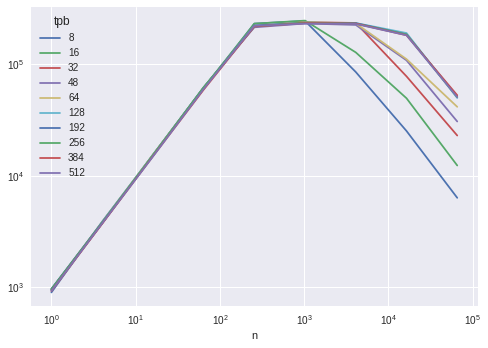

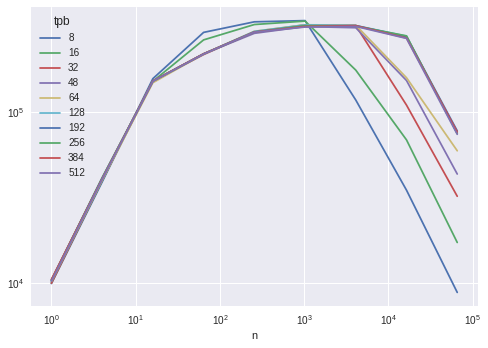

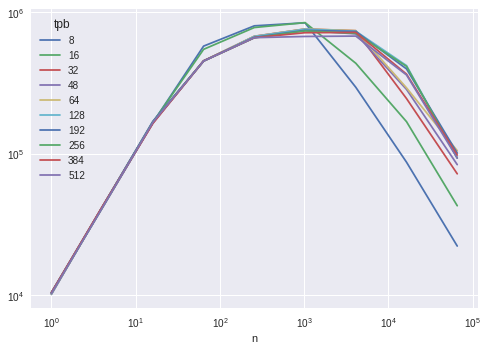

In [0]:
tpb_times.pivot_table('pups', tpb_times.n, ('solver', 'tpb')).NumbaSolver.plot(logx=True, logy=True)
tpb_times.pivot_table('pups', tpb_times.n, ('solver', 'tpb')).CudaSolver.plot(logx=True, logy=True)
tpb_times.pivot_table('pups', tpb_times.n, ('solver', 'tpb')).OpenCLSolver.plot(logx=True, logy=True)

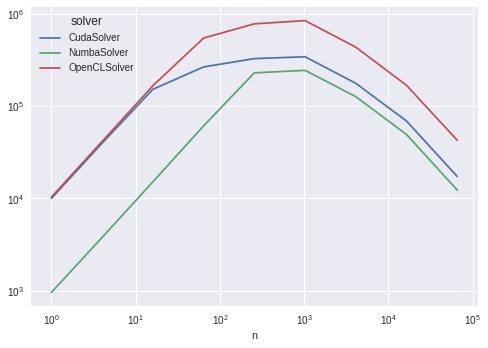

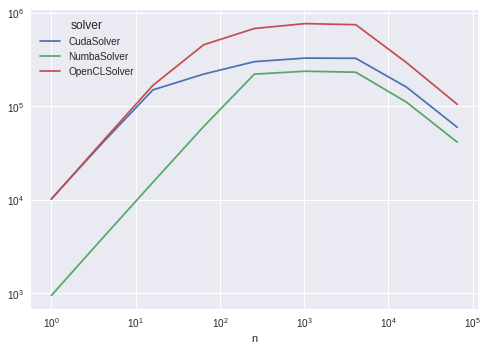

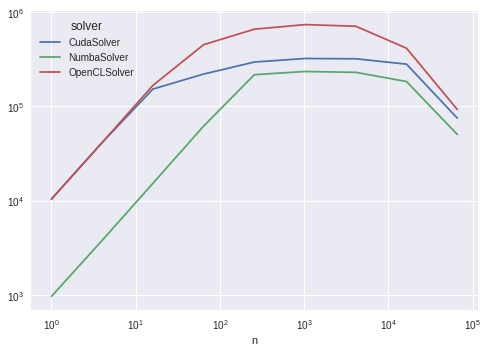

In [0]:
tpb_times.pivot_table('pups', tpb_times.n, ('tpb', 'solver'))[16].plot(logx=True, logy=True)
tpb_times.pivot_table('pups', tpb_times.n, ('tpb', 'solver'))[64].plot(logx=True, logy=True)
tpb_times.pivot_table('pups', tpb_times.n, ('tpb', 'solver'))[256].plot(logx=True, logy=True)


## Scalar and types

In [0]:
def gen_scalar_params():
  for scalar in True, False:
    form = CoordFormat.nx
    compound = True
    yield locals()   
raw = list(benchmark_all(GPU_solvers, params=gen_scalar_params, types=gen_sane_types))

NumbaSolver
{'pos_t': 'float32', 'vel_t': 'float32', 'time_t': 'float32', 'mass_t': 'int32', 'charge_t': 'int32'}
{'compound': True, 'form': 'nx', 'scalar': True, 'tpb': 64}
1,8192.00: 8.00 2,8192.00: 8.13 4,8192.00: 8.17 8,8192.00: 8.17 16,8192.00: 8.30 32,4608.00: 14.64 64,1152.00: 14.83 128,72.00: 8.23 256,4.50: 6.30 
{'compound': True, 'form': 'nx', 'scalar': False, 'tpb': 64}
1,8192.00: 8.99 2,8192.00: 9.35 4,8192.00: 8.82 8,8192.00: 9.11 16,8192.00: 8.97 32,4608.00: 17.18 64,1152.00: 17.93 128,72.00: 9.54 256,4.50: 7.19 
{'pos_t': 'float32', 'vel_t': 'float32', 'time_t': 'float32', 'mass_t': 'float32', 'charge_t': 'float32'}
{'compound': True, 'form': 'nx', 'scalar': True, 'tpb': 64}
1,8192.00: 8.22 2,8192.00: 8.17 4,8192.00: 8.27 8,8192.00: 8.55 16,8192.00: 8.12 32,4608.00: 15.61 64,1152.00: 15.93 128,72.00: 8.48 256,4.50: 6.32 
{'compound': True, 'form': 'nx', 'scalar': False, 'tpb': 64}
1,8192.00: 9.34 2,8192.00: 8.99 4,8192.00: 8.86 8,8192.00: 9.11 16,8192.00: 9.60 32,4608.00

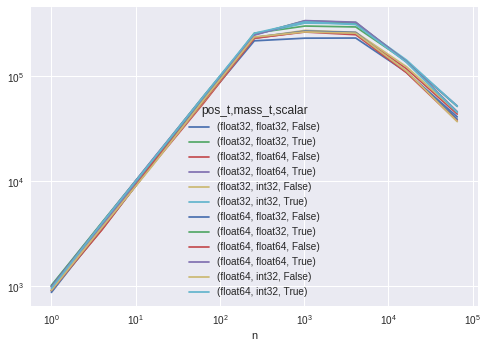

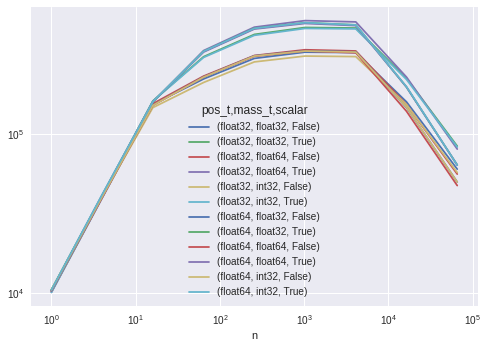

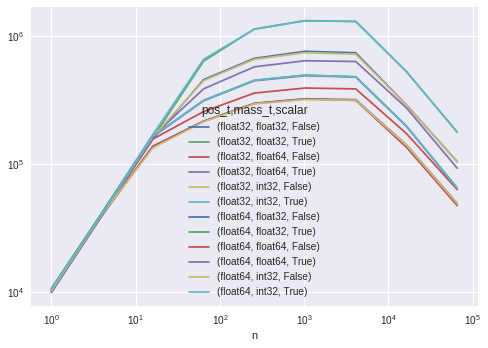

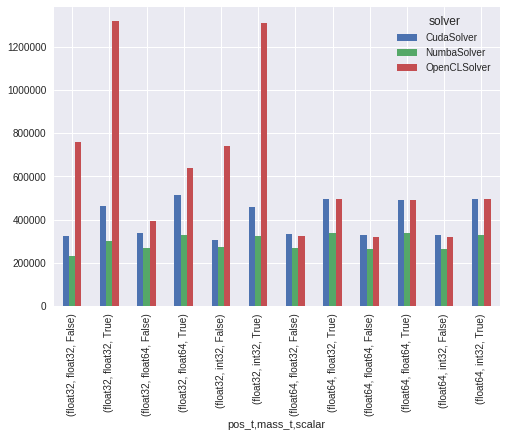

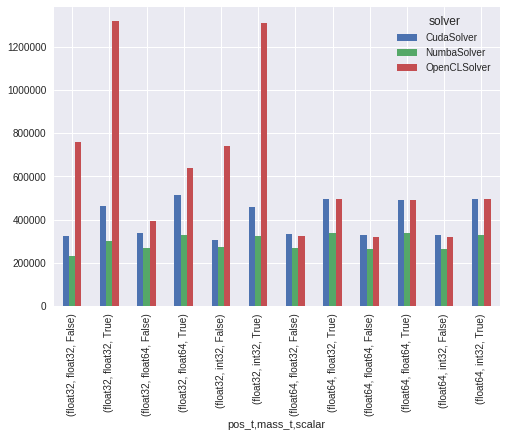

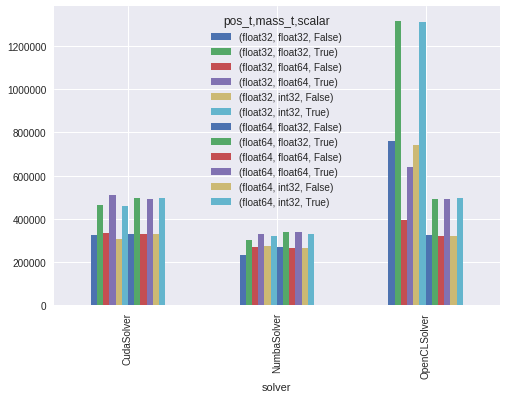

In [0]:
type_times = process_perf(raw)
type_times.to_csv("/drive/My Drive/type.csv")
t = type_times
t.pivot_table('pups', 'n', ('solver', 'pos_t', 'mass_t', 'scalar')).NumbaSolver.plot(logx=True, logy=True)
t.pivot_table('pups', 'n', ('solver', 'pos_t', 'mass_t', 'scalar')).CudaSolver.plot(logx=True, logy=True)
t.pivot_table('pups', 'n', ('solver', 'pos_t', 'mass_t', 'scalar')).OpenCLSolver.plot(logx=True, logy=True)
t[t.n==1024].pivot_table('pups', ('pos_t', 'mass_t', 'scalar'), 'solver').plot(kind='bar')
t[t.n==1024].pivot_table('pups', ('pos_t', 'mass_t', 'scalar'), 'solver').plot(kind='bar')
t[t.n==1024].pivot_table('pups', 'solver', ('pos_t', 'mass_t', 'scalar')).plot(kind='bar')


## CPU solvers

In [0]:
def gen_limited_params():
  form = CoordFormat.split
  scalar = True
  compound = True
  yield locals()
  
raw = list(benchmark_all(limited_solvers, scales=gen_scales(), types=gen_sane_types, params=gen_limited_params, time_grow_limit=16))

NameError: ignored

In [0]:
cpu_times = process_perf(raw)
cpu_times.to_csv("/drive/My Drive/cpu.csv")


In [0]:
t = cpu_times
t[t.solver=="PythonSolver"].pivot_table('pups', 'n', ('pos_t', 'mass_t')).plot(logx=True, logy=True)
t[t.solver!="PythonSolver"].pivot_table('pups', 'n', ('solver', 'pos_t', 'mass_t')).plot(logx=True, logy=True)


In [0]:
t[t.n==64].pivot_table('pups', 'solver', ('pos_t', 'mass_t')).plot(kind='bar')
t[t.n==256].pivot_table('pups', 'solver', ('pos_t', 'mass_t')).plot(kind='bar')


In [0]:
benchmark_all(solvers, scales=gen_scales_basic(), tpbs=one_tpbs, types=gen_one_types, params=gen_one_params, time_grow_limit=4, max_batch=8192_

## compare to slides

In [0]:
batch = 100
numba_n  = np.array((100, 200, 300, 500, 700, 1000, 1500, 2000, 3000, 5000))
numba_t  = np.array((131, 133, 154, 244, 335, 474, 706, 939, 1420, 2410))
cuda_n   = np.array((100, 200, 300, 500, 700, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000, 500000, 1000000))
cuda_t   = np.array((12.9, 13, 13.2, 13.2, 12.9, 13.8, 14.7, 15.4, 15.9, 18.3, 22.2, 68.8, 127, 510, 981))
opencl_n = np.array((100, 200, 300, 500, 700, 1000, 1500, 2000, 3000, 5000, 7000, 10000, 15000, 20000))
opencl_t = np.array((2020, 2030, 2040, 2040, 2060, 2060, 2130, 2120, 2190, 2340, 2480, 2850, 3890, 5340))
python_n = np.array((10, 20, 30, 50, 70, 100, 150, 200, 300))
python_t = np.array((34.1, 97.6, 188, 462, 876, 1730, 3850, 6750, 14800))
slide_times = pd.concat([
  pd.DataFrame({"runner": f"{r}_old", "n": globals()[f"{r}_n"], "time": globals()[f"{r}_t"]/1000})
  for r in ("numba", "cuda", "opencl", "python")])

In [0]:
slide_times["batch"] = 100
timeplot(slide_times)


In [0]:
renamed = interesting_times.copy()
renamed.runner[renamed.runner=="numpy_simple_float"]="python_numpy_simple_float"
timeplot(renamed)
timeplot(slide_times, style="--")